In [3]:
import sys
!{sys.executable} -m pip install torch torchvision matplotlib 

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import sys
sys.path.insert(0, "/home/hice1/jmaayah3/.local/lib/python3.10/site-packages")

!{sys.executable} -m pip install --user --upgrade typing-extensions torch

In [1]:
!conda env update --file invis-env.yaml --prune

Channels:
 - pytorch
 - nvidia
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

pytorch-2.5.1        | 1.35 GB   |                                       |   0% 
libcusolver-11.4.4.5 | 98.3 MB   |                                       |   0% 

libllvm21-21.1.5     | 42.3 MB   |                                       |   0% 


babel-2.17.0         | 6.6 MB    |                                       |   0% 



intel-openmp-2022.1. | 4.5 MB    |                                       |   0% 




fonttools-4.60.1     | 2.3 MB    |                                       |   0% 





harfbuzz-12.2.0      | 2.3 MB    |                                       |   0% 






debugpy-1.8.17       | 2.1 MB    |                                       |   0% 







gnutls-3.6.13        | 2.0 MB    |                                       |   0% 








alsa-lib-1.2.14      | 553 KB    |                                       |   0% 
libcusolver-11.4.4.5 | 98.3 MB   |                

In [6]:
!pip install "numpy<2"


Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [Errno 16] Device or resource busy: '.nfs000000005c3f422000000bc2'



In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
%matplotlib inline


In [2]:
# Training hyperparameters
DATASET = "MNIST" #["MNIST", "CIFAR10", "CIFAR100"]
# Our midpoint project submission only uses the MNIST dataset

EPOCHS = 30
BATCH_SIZE = 64
LATENT_DIM = 100
MESSAGE_WIDTH = 16

ADV_WEIGHT = 0.1
AUX_WEIGHT = 0.9

if DATASET == "MNIST":
    IMAGE_SHAPE = (1, 28, 28)
    SINGLE_CHANNEL = True
elif DATASET == "CIFAR10" or DATASET == "CIFAR100":
    IMAGE_SHAPE = (3, 32, 32)
    SINGLE_CHANNEL = False

# Model hyperparameters
GENERATOR_NUM_FILTERS = 256
DISCRIMINATOR_NUM_FILTERS = 128
DECODER_NUM_FILTERS = 64
# Save paths
ANIMATION_DIR = "invisigan_generated_images"
CHECKPOINT_DIR = "invisigan_model_checkpoints"

In [3]:
# MPS backend
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Data preprocessing
if SINGLE_CHANNEL:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]) # mean, std
    ])
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]) # mean, std for all 3 channels
    ])

In [5]:
# Load dataset
if DATASET == "MNIST":
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
elif DATASET == "CIFAR10":
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
elif DATASET == "CIFAR100":
    trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

dataloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, msg_width, img_shape, base_filters=128):
        super().__init__()
        self.init_size = img_shape[1] // 4

        # Initial projections
        self.l1 = nn.Linear(latent_dim, base_filters * self.init_size ** 2)
        self.msg_proj0 = nn.Linear(msg_width, latent_dim)

        # Message projections for each block
        self.msg_proj1 = nn.Linear(msg_width, base_filters)
        self.msg_proj2 = nn.Linear(msg_width, base_filters)

        # Upsample blocks
        self.block1 = nn.Sequential(
            nn.BatchNorm2d(base_filters),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(base_filters, base_filters, 3, 1, 1),
            nn.BatchNorm2d(base_filters, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.block2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(base_filters, base_filters // 2, 3, 1, 1),
            nn.BatchNorm2d(base_filters // 2, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_filters // 2, img_shape[0], 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, z, msg):
        # Add message embedding
        z = z + self.msg_proj0(msg)
        out = self.l1(z).view(z.size(0), -1, self.init_size, self.init_size)

        # Inject message after first upsample
        msg1 = self.msg_proj1(msg).view(msg.size(0), -1, 1, 1)
        out = out + msg1
        out = self.block1(out)

        # Inject message after second upsample
        msg2 = self.msg_proj2(msg).view(msg.size(0), -1, 1, 1)
        out = out + msg2.expand(-1, -1, out.size(2), out.size(3))
        img = self.block2(out)

        return img



class Discriminator(nn.Module):
    def __init__(self, img_shape, base_filters=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_shape[0], base_filters, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(base_filters, base_filters * 2, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(base_filters * 2, base_filters * 4, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
        )
        _ = torch.zeros(1, *img_shape)
        flat_dim = self.model(_).shape[1]
        self.fc = nn.Linear(flat_dim, 1)

    def forward(self, img):
        return self.fc(self.model(img))


class Decoder(nn.Module):
    def __init__(self, img_shape, msg_width):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_shape[0], 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * (img_shape[1] // 4) * (img_shape[2] // 4), 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, msg_width),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)


In [7]:
# Instantiate networks
generator = Generator(LATENT_DIM, MESSAGE_WIDTH, IMAGE_SHAPE, GENERATOR_NUM_FILTERS).to(device)
discriminator = Discriminator(IMAGE_SHAPE, DISCRIMINATOR_NUM_FILTERS).to(device)
decoder = Decoder(IMAGE_SHAPE, MESSAGE_WIDTH).to(device)

decoder_loss = nn.BCELoss()

# Instantiate optimizers
gen_optim = optim.Adam(generator.parameters(), lr=0.0001)
disc_optim = optim.Adam(discriminator.parameters(), lr=0.0001)
dec_opt = optim.Adam(decoder.parameters(), lr=0.0001)


In [8]:
def train():
    for epoch in range(EPOCHS):
        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)

            # Train discriminator
            disc_optim.zero_grad()

            z = torch.randn(imgs.size(0), LATENT_DIM, device=device)
            msgs = torch.randint(0, 2, (imgs.size(0), MESSAGE_WIDTH), device=device, dtype=torch.float)
            fake_imgs = generator(z, msgs).detach()

            real_pred = discriminator(imgs)
            fake_pred = discriminator(fake_imgs)

            real_loss = torch.mean(F.relu(1.0 - real_pred))
            fake_loss = torch.mean(F.relu(1.0 + fake_pred))
            disc_loss = real_loss + fake_loss
            disc_loss.backward()
            disc_optim.step()

            # Train generator and decoder
            gen_optim.zero_grad()
            dec_opt.zero_grad()

            z = torch.randn(imgs.size(0), LATENT_DIM, device=device)
            msgs = torch.randint(0, 2, (imgs.size(0), MESSAGE_WIDTH), device=device, dtype=torch.float)
            gen_imgs = generator(z, msgs)
            validity = discriminator(gen_imgs)
            decoded = decoder(gen_imgs)

            gen_adv_loss = -torch.mean(validity)
            gen_aux_loss = decoder_loss(decoded, msgs)
            gen_loss = ADV_WEIGHT * gen_adv_loss + AUX_WEIGHT * gen_aux_loss

            gen_loss.backward()
            gen_optim.step()
            dec_opt.step()

            # Metrics
            pred_bits = (decoded > 0.5).float()
            bitwise_acc = (pred_bits == msgs).float().mean().item()
            full_recovery = ((pred_bits == msgs).all(dim=1).float().mean().item())

            if (i + 1) % 100 == 0:
                print(f"[Epoch {epoch}/{EPOCHS}] [Batch {i}/{len(dataloader)}] "
                      f"[D loss: {disc_loss.item():.3f}] [G loss: {gen_loss.item():.3f}] "
                      f"(Adv: {gen_adv_loss.item():.3f}, Dec: {gen_aux_loss.item():.3f}) "
                      f"[Bit acc: {bitwise_acc:.3f}] [Full rec: {full_recovery:.3f}]")

        # Checkpoint each model
        torch.save(generator, "generator1.pth")
        torch.save(discriminator, "discriminator1.pth")
        torch.save(decoder, "decoder1.pth")

        with torch.no_grad():
            z = torch.randn(25, LATENT_DIM, device=device)
            msg = torch.randint(0, 2, (25, MESSAGE_WIDTH), device=device, dtype=torch.float)
            samples = generator(z, msg).cpu()
            samples = (samples + 1) / 2  # [-1,1] -> [0,1]
            grid = np.transpose(samples, (0, 2, 3, 1))

        fig, axes = plt.subplots(5, 5, figsize=(6, 6))
        for j, ax in enumerate(axes.flatten()):
            ax.imshow(grid[j])
            ax.axis("off")
        plt.tight_layout()
        plt.show()



In [9]:
def show_samples():
    with torch.no_grad():
        z = torch.randn(25, LATENT_DIM, device=device)
        msg = torch.randint(0, 2, (25, MESSAGE_WIDTH), device=device, dtype=torch.float)
        samples = generator(z, msg).cpu()
        grid = np.transpose((samples + 1) / 2, (0, 2, 3, 1))

    fig, axes = plt.subplots(5, 5, figsize=(6, 6))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(grid[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()


[Epoch 0/30] [Batch 99/938] [D loss: 0.549] [G loss: 0.778] (Adv: 1.546, Dec: 0.693) [Bit acc: 0.522] [Full rec: 0.000]
[Epoch 0/30] [Batch 199/938] [D loss: 0.356] [G loss: 0.903] (Adv: 2.828, Dec: 0.689) [Bit acc: 0.539] [Full rec: 0.000]
[Epoch 0/30] [Batch 299/938] [D loss: 0.464] [G loss: 0.749] (Adv: 1.360, Dec: 0.681) [Bit acc: 0.577] [Full rec: 0.000]
[Epoch 0/30] [Batch 399/938] [D loss: 0.016] [G loss: 0.806] (Adv: 1.935, Dec: 0.681) [Bit acc: 0.545] [Full rec: 0.000]
[Epoch 0/30] [Batch 499/938] [D loss: 0.106] [G loss: 0.844] (Adv: 2.342, Dec: 0.677) [Bit acc: 0.565] [Full rec: 0.000]
[Epoch 0/30] [Batch 599/938] [D loss: 0.032] [G loss: 0.828] (Adv: 2.128, Dec: 0.683) [Bit acc: 0.559] [Full rec: 0.000]
[Epoch 0/30] [Batch 699/938] [D loss: 0.000] [G loss: 0.880] (Adv: 2.799, Dec: 0.667) [Bit acc: 0.583] [Full rec: 0.000]
[Epoch 0/30] [Batch 799/938] [D loss: 0.000] [G loss: 0.874] (Adv: 2.834, Dec: 0.657) [Bit acc: 0.621] [Full rec: 0.000]
[Epoch 0/30] [Batch 899/938] [D l

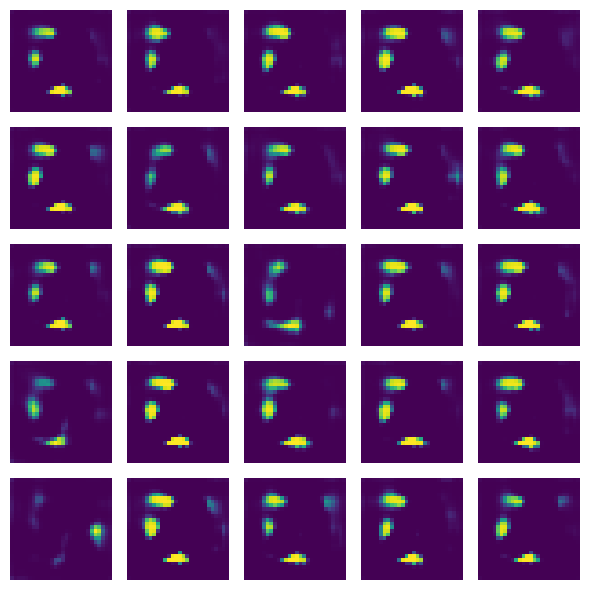

[Epoch 1/30] [Batch 99/938] [D loss: 1.175] [G loss: 0.763] (Adv: 1.438, Dec: 0.688) [Bit acc: 0.533] [Full rec: 0.000]
[Epoch 1/30] [Batch 199/938] [D loss: 0.796] [G loss: 0.983] (Adv: 3.669, Dec: 0.684) [Bit acc: 0.548] [Full rec: 0.000]
[Epoch 1/30] [Batch 299/938] [D loss: 0.702] [G loss: 0.941] (Adv: 3.347, Dec: 0.674) [Bit acc: 0.577] [Full rec: 0.000]
[Epoch 1/30] [Batch 399/938] [D loss: 1.066] [G loss: 1.034] (Adv: 4.238, Dec: 0.678) [Bit acc: 0.567] [Full rec: 0.000]
[Epoch 1/30] [Batch 499/938] [D loss: 0.006] [G loss: 0.908] (Adv: 2.978, Dec: 0.678) [Bit acc: 0.556] [Full rec: 0.000]
[Epoch 1/30] [Batch 599/938] [D loss: 0.765] [G loss: 1.003] (Adv: 3.536, Dec: 0.721) [Bit acc: 0.532] [Full rec: 0.000]
[Epoch 1/30] [Batch 699/938] [D loss: 1.552] [G loss: 0.818] (Adv: 2.309, Dec: 0.652) [Bit acc: 0.606] [Full rec: 0.000]
[Epoch 1/30] [Batch 799/938] [D loss: 0.435] [G loss: 1.070] (Adv: 4.647, Dec: 0.672) [Bit acc: 0.585] [Full rec: 0.000]
[Epoch 1/30] [Batch 899/938] [D l

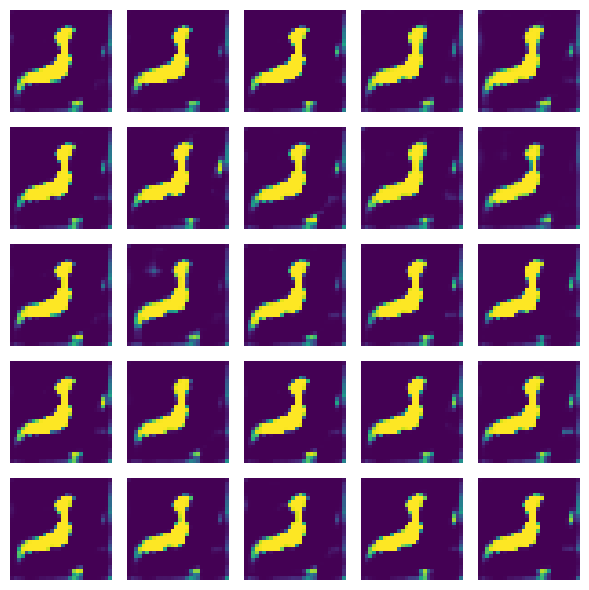

[Epoch 2/30] [Batch 99/938] [D loss: 0.299] [G loss: 0.869] (Adv: 2.645, Dec: 0.672) [Bit acc: 0.583] [Full rec: 0.000]
[Epoch 2/30] [Batch 199/938] [D loss: 0.176] [G loss: 0.833] (Adv: 2.229, Dec: 0.678) [Bit acc: 0.587] [Full rec: 0.000]
[Epoch 2/30] [Batch 299/938] [D loss: 0.254] [G loss: 0.896] (Adv: 2.962, Dec: 0.667) [Bit acc: 0.587] [Full rec: 0.000]
[Epoch 2/30] [Batch 399/938] [D loss: 0.040] [G loss: 0.877] (Adv: 2.693, Dec: 0.675) [Bit acc: 0.590] [Full rec: 0.000]
[Epoch 2/30] [Batch 499/938] [D loss: 0.102] [G loss: 0.865] (Adv: 2.565, Dec: 0.676) [Bit acc: 0.578] [Full rec: 0.000]
[Epoch 2/30] [Batch 599/938] [D loss: 0.232] [G loss: 0.920] (Adv: 3.164, Dec: 0.670) [Bit acc: 0.583] [Full rec: 0.000]
[Epoch 2/30] [Batch 699/938] [D loss: 1.233] [G loss: 0.733] (Adv: 1.179, Dec: 0.683) [Bit acc: 0.554] [Full rec: 0.000]
[Epoch 2/30] [Batch 799/938] [D loss: 0.299] [G loss: 0.968] (Adv: 3.583, Dec: 0.678) [Bit acc: 0.579] [Full rec: 0.000]
[Epoch 2/30] [Batch 899/938] [D l

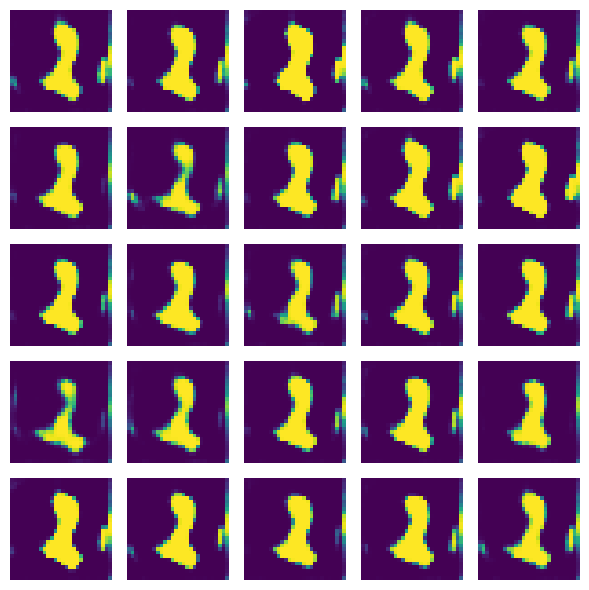

[Epoch 3/30] [Batch 99/938] [D loss: 0.026] [G loss: 0.934] (Adv: 3.077, Dec: 0.696) [Bit acc: 0.501] [Full rec: 0.000]
[Epoch 3/30] [Batch 199/938] [D loss: 0.006] [G loss: 0.930] (Adv: 3.284, Dec: 0.668) [Bit acc: 0.613] [Full rec: 0.000]
[Epoch 3/30] [Batch 299/938] [D loss: 0.341] [G loss: 0.966] (Adv: 3.645, Dec: 0.668) [Bit acc: 0.584] [Full rec: 0.000]
[Epoch 3/30] [Batch 399/938] [D loss: 0.052] [G loss: 0.935] (Adv: 3.428, Dec: 0.658) [Bit acc: 0.599] [Full rec: 0.000]
[Epoch 3/30] [Batch 499/938] [D loss: 0.148] [G loss: 0.915] (Adv: 3.188, Dec: 0.662) [Bit acc: 0.593] [Full rec: 0.000]
[Epoch 3/30] [Batch 599/938] [D loss: 0.214] [G loss: 0.951] (Adv: 3.411, Dec: 0.678) [Bit acc: 0.571] [Full rec: 0.000]
[Epoch 3/30] [Batch 699/938] [D loss: 0.266] [G loss: 0.845] (Adv: 2.318, Dec: 0.681) [Bit acc: 0.575] [Full rec: 0.000]
[Epoch 3/30] [Batch 799/938] [D loss: 0.027] [G loss: 0.858] (Adv: 2.807, Dec: 0.641) [Bit acc: 0.627] [Full rec: 0.000]
[Epoch 3/30] [Batch 899/938] [D l

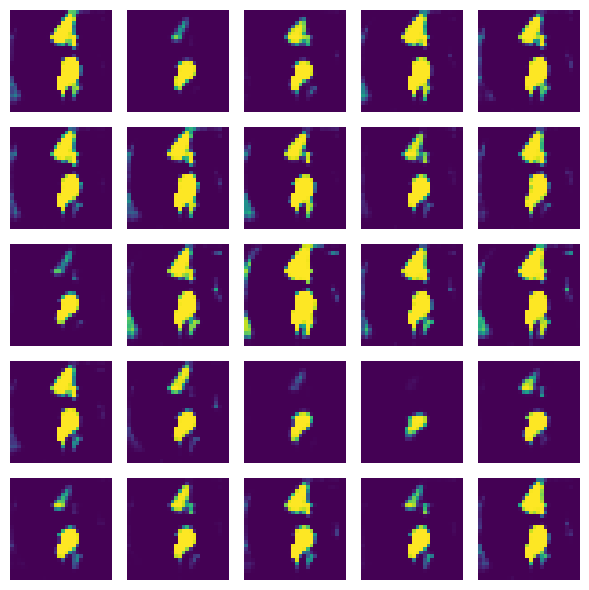

[Epoch 4/30] [Batch 99/938] [D loss: 0.079] [G loss: 0.846] (Adv: 2.505, Dec: 0.662) [Bit acc: 0.617] [Full rec: 0.000]
[Epoch 4/30] [Batch 199/938] [D loss: 0.034] [G loss: 0.869] (Adv: 2.879, Dec: 0.645) [Bit acc: 0.642] [Full rec: 0.000]
[Epoch 4/30] [Batch 299/938] [D loss: 0.247] [G loss: 0.853] (Adv: 2.939, Dec: 0.621) [Bit acc: 0.651] [Full rec: 0.000]
[Epoch 4/30] [Batch 399/938] [D loss: 0.094] [G loss: 0.918] (Adv: 3.373, Dec: 0.645) [Bit acc: 0.634] [Full rec: 0.000]
[Epoch 4/30] [Batch 499/938] [D loss: 0.228] [G loss: 0.968] (Adv: 3.642, Dec: 0.671) [Bit acc: 0.582] [Full rec: 0.000]
[Epoch 4/30] [Batch 599/938] [D loss: 0.125] [G loss: 1.081] (Adv: 4.576, Dec: 0.693) [Bit acc: 0.539] [Full rec: 0.000]
[Epoch 4/30] [Batch 699/938] [D loss: 0.224] [G loss: 0.856] (Adv: 2.738, Dec: 0.647) [Bit acc: 0.628] [Full rec: 0.000]
[Epoch 4/30] [Batch 799/938] [D loss: 0.311] [G loss: 0.850] (Adv: 2.637, Dec: 0.651) [Bit acc: 0.616] [Full rec: 0.000]
[Epoch 4/30] [Batch 899/938] [D l

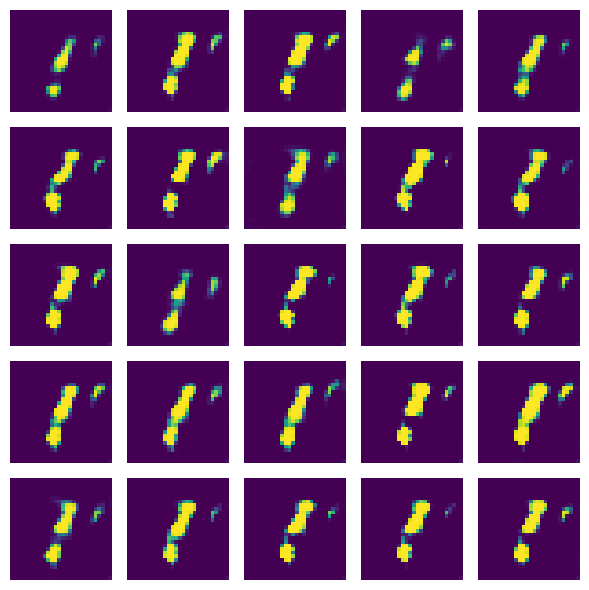

[Epoch 5/30] [Batch 99/938] [D loss: 0.088] [G loss: 0.881] (Adv: 2.772, Dec: 0.671) [Bit acc: 0.584] [Full rec: 0.000]
[Epoch 5/30] [Batch 199/938] [D loss: 0.257] [G loss: 0.930] (Adv: 3.475, Dec: 0.648) [Bit acc: 0.604] [Full rec: 0.000]
[Epoch 5/30] [Batch 299/938] [D loss: 0.126] [G loss: 1.128] (Adv: 5.427, Dec: 0.650) [Bit acc: 0.632] [Full rec: 0.000]
[Epoch 5/30] [Batch 399/938] [D loss: 0.246] [G loss: 0.948] (Adv: 3.776, Dec: 0.634) [Bit acc: 0.635] [Full rec: 0.000]
[Epoch 5/30] [Batch 499/938] [D loss: 0.381] [G loss: 0.922] (Adv: 3.491, Dec: 0.636) [Bit acc: 0.649] [Full rec: 0.000]
[Epoch 5/30] [Batch 599/938] [D loss: 0.101] [G loss: 0.936] (Adv: 3.446, Dec: 0.658) [Bit acc: 0.601] [Full rec: 0.000]
[Epoch 5/30] [Batch 699/938] [D loss: 0.328] [G loss: 0.898] (Adv: 3.109, Dec: 0.652) [Bit acc: 0.614] [Full rec: 0.000]
[Epoch 5/30] [Batch 799/938] [D loss: 0.379] [G loss: 0.851] (Adv: 2.790, Dec: 0.636) [Bit acc: 0.650] [Full rec: 0.000]
[Epoch 5/30] [Batch 899/938] [D l

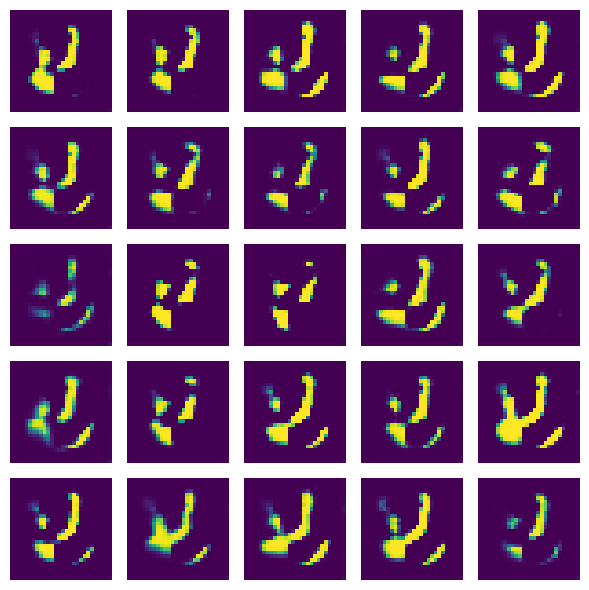

[Epoch 6/30] [Batch 99/938] [D loss: 0.104] [G loss: 0.906] (Adv: 3.544, Dec: 0.613) [Bit acc: 0.662] [Full rec: 0.000]
[Epoch 6/30] [Batch 199/938] [D loss: 0.169] [G loss: 0.808] (Adv: 2.459, Dec: 0.625) [Bit acc: 0.635] [Full rec: 0.000]
[Epoch 6/30] [Batch 299/938] [D loss: 0.212] [G loss: 0.903] (Adv: 3.381, Dec: 0.628) [Bit acc: 0.655] [Full rec: 0.000]
[Epoch 6/30] [Batch 399/938] [D loss: 0.022] [G loss: 0.967] (Adv: 4.251, Dec: 0.602) [Bit acc: 0.671] [Full rec: 0.000]
[Epoch 6/30] [Batch 499/938] [D loss: 0.080] [G loss: 0.931] (Adv: 3.826, Dec: 0.610) [Bit acc: 0.678] [Full rec: 0.000]
[Epoch 6/30] [Batch 599/938] [D loss: 0.140] [G loss: 0.803] (Adv: 2.535, Dec: 0.611) [Bit acc: 0.661] [Full rec: 0.000]
[Epoch 6/30] [Batch 699/938] [D loss: 0.262] [G loss: 0.873] (Adv: 3.522, Dec: 0.579) [Bit acc: 0.705] [Full rec: 0.016]
[Epoch 6/30] [Batch 799/938] [D loss: 0.172] [G loss: 0.759] (Adv: 2.313, Dec: 0.586) [Bit acc: 0.677] [Full rec: 0.000]
[Epoch 6/30] [Batch 899/938] [D l

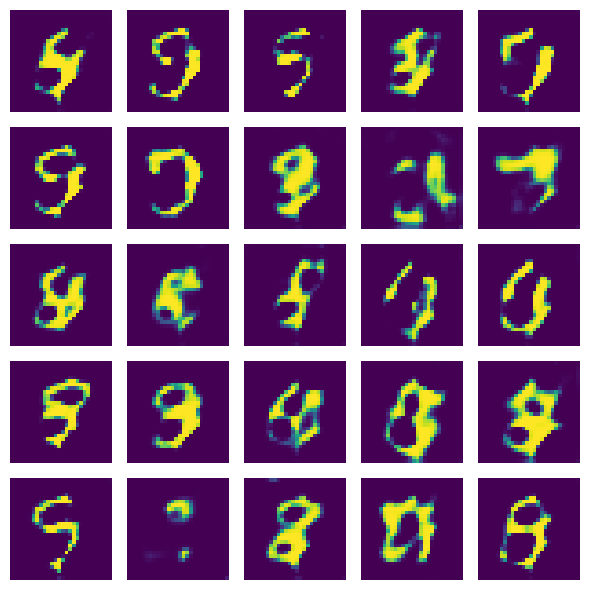

[Epoch 7/30] [Batch 99/938] [D loss: 0.592] [G loss: 0.695] (Adv: 1.980, Dec: 0.553) [Bit acc: 0.717] [Full rec: 0.016]
[Epoch 7/30] [Batch 199/938] [D loss: 0.324] [G loss: 0.706] (Adv: 2.091, Dec: 0.552) [Bit acc: 0.729] [Full rec: 0.000]
[Epoch 7/30] [Batch 299/938] [D loss: 0.607] [G loss: 0.661] (Adv: 1.590, Dec: 0.557) [Bit acc: 0.721] [Full rec: 0.000]
[Epoch 7/30] [Batch 399/938] [D loss: 0.374] [G loss: 0.669] (Adv: 1.929, Dec: 0.529) [Bit acc: 0.734] [Full rec: 0.016]
[Epoch 7/30] [Batch 499/938] [D loss: 0.545] [G loss: 0.646] (Adv: 1.796, Dec: 0.518) [Bit acc: 0.741] [Full rec: 0.016]
[Epoch 7/30] [Batch 599/938] [D loss: 0.619] [G loss: 0.641] (Adv: 1.836, Dec: 0.508) [Bit acc: 0.763] [Full rec: 0.000]
[Epoch 7/30] [Batch 699/938] [D loss: 0.340] [G loss: 0.613] (Adv: 1.390, Dec: 0.527) [Bit acc: 0.730] [Full rec: 0.016]
[Epoch 7/30] [Batch 799/938] [D loss: 0.420] [G loss: 0.591] (Adv: 1.379, Dec: 0.504) [Bit acc: 0.743] [Full rec: 0.016]
[Epoch 7/30] [Batch 899/938] [D l

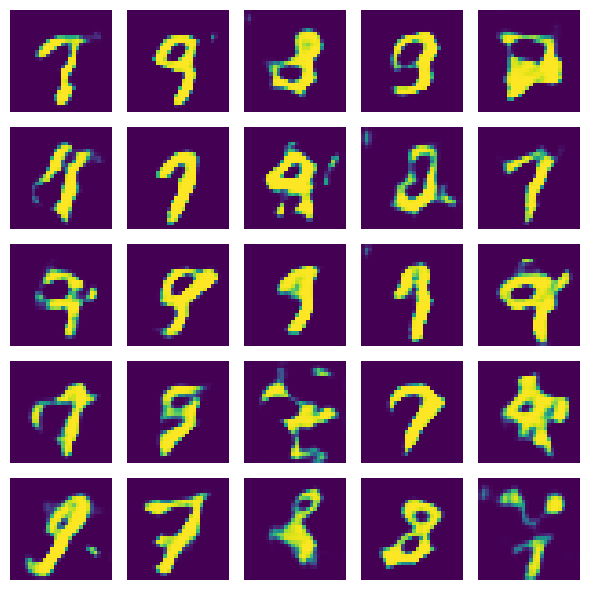

[Epoch 8/30] [Batch 99/938] [D loss: 0.633] [G loss: 0.613] (Adv: 1.713, Dec: 0.490) [Bit acc: 0.763] [Full rec: 0.016]
[Epoch 8/30] [Batch 199/938] [D loss: 0.592] [G loss: 0.609] (Adv: 1.503, Dec: 0.510) [Bit acc: 0.745] [Full rec: 0.000]
[Epoch 8/30] [Batch 299/938] [D loss: 0.578] [G loss: 0.491] (Adv: 0.927, Dec: 0.443) [Bit acc: 0.795] [Full rec: 0.016]
[Epoch 8/30] [Batch 399/938] [D loss: 0.770] [G loss: 0.559] (Adv: 1.578, Dec: 0.446) [Bit acc: 0.796] [Full rec: 0.016]
[Epoch 8/30] [Batch 499/938] [D loss: 0.588] [G loss: 0.515] (Adv: 1.085, Dec: 0.452) [Bit acc: 0.782] [Full rec: 0.031]
[Epoch 8/30] [Batch 599/938] [D loss: 0.813] [G loss: 0.532] (Adv: 1.258, Dec: 0.451) [Bit acc: 0.779] [Full rec: 0.031]
[Epoch 8/30] [Batch 699/938] [D loss: 0.768] [G loss: 0.485] (Adv: 1.001, Dec: 0.428) [Bit acc: 0.808] [Full rec: 0.031]
[Epoch 8/30] [Batch 799/938] [D loss: 0.703] [G loss: 0.528] (Adv: 1.733, Dec: 0.394) [Bit acc: 0.831] [Full rec: 0.031]
[Epoch 8/30] [Batch 899/938] [D l

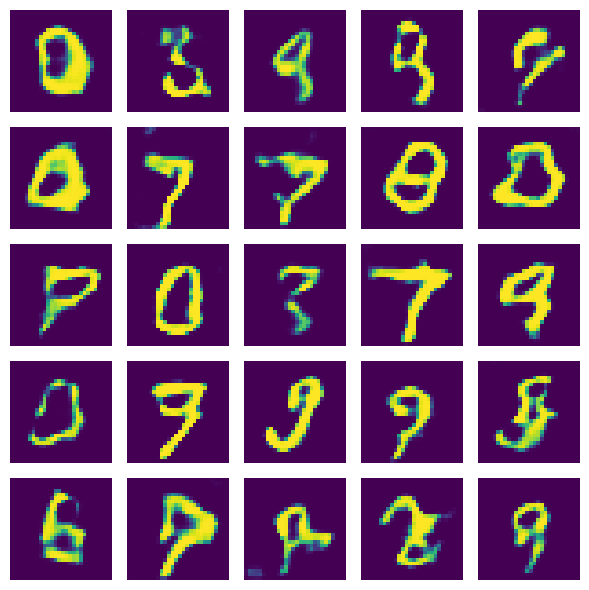

[Epoch 9/30] [Batch 99/938] [D loss: 0.789] [G loss: 0.468] (Adv: 1.287, Dec: 0.377) [Bit acc: 0.848] [Full rec: 0.125]
[Epoch 9/30] [Batch 199/938] [D loss: 0.685] [G loss: 0.481] (Adv: 1.342, Dec: 0.385) [Bit acc: 0.822] [Full rec: 0.047]
[Epoch 9/30] [Batch 299/938] [D loss: 0.456] [G loss: 0.521] (Adv: 1.678, Dec: 0.393) [Bit acc: 0.827] [Full rec: 0.062]
[Epoch 9/30] [Batch 399/938] [D loss: 0.572] [G loss: 0.453] (Adv: 1.244, Dec: 0.365) [Bit acc: 0.861] [Full rec: 0.109]
[Epoch 9/30] [Batch 499/938] [D loss: 0.659] [G loss: 0.446] (Adv: 1.274, Dec: 0.354) [Bit acc: 0.844] [Full rec: 0.094]
[Epoch 9/30] [Batch 599/938] [D loss: 0.589] [G loss: 0.454] (Adv: 1.314, Dec: 0.358) [Bit acc: 0.845] [Full rec: 0.062]
[Epoch 9/30] [Batch 699/938] [D loss: 0.780] [G loss: 0.452] (Adv: 1.350, Dec: 0.352) [Bit acc: 0.843] [Full rec: 0.062]
[Epoch 9/30] [Batch 799/938] [D loss: 0.605] [G loss: 0.417] (Adv: 1.102, Dec: 0.341) [Bit acc: 0.855] [Full rec: 0.047]
[Epoch 9/30] [Batch 899/938] [D l

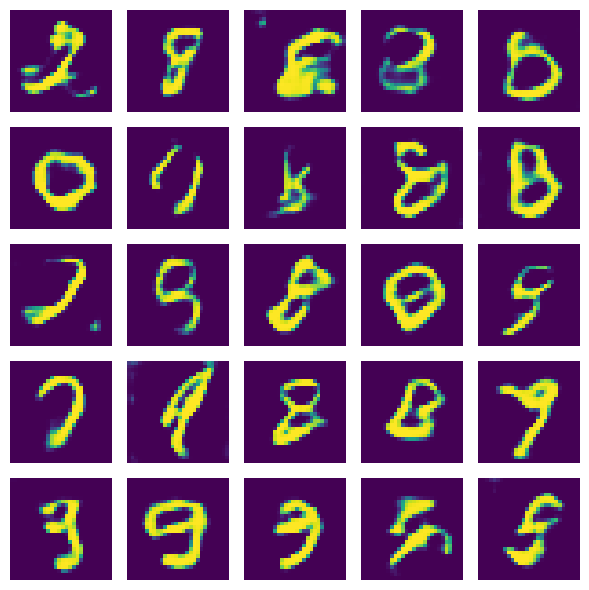

[Epoch 10/30] [Batch 99/938] [D loss: 0.650] [G loss: 0.417] (Adv: 1.103, Dec: 0.341) [Bit acc: 0.856] [Full rec: 0.062]
[Epoch 10/30] [Batch 199/938] [D loss: 0.846] [G loss: 0.426] (Adv: 1.224, Dec: 0.338) [Bit acc: 0.855] [Full rec: 0.094]
[Epoch 10/30] [Batch 299/938] [D loss: 0.849] [G loss: 0.386] (Adv: 1.022, Dec: 0.315) [Bit acc: 0.866] [Full rec: 0.141]
[Epoch 10/30] [Batch 399/938] [D loss: 0.824] [G loss: 0.396] (Adv: 1.302, Dec: 0.296) [Bit acc: 0.875] [Full rec: 0.109]
[Epoch 10/30] [Batch 499/938] [D loss: 0.769] [G loss: 0.383] (Adv: 1.033, Dec: 0.311) [Bit acc: 0.871] [Full rec: 0.141]
[Epoch 10/30] [Batch 599/938] [D loss: 0.741] [G loss: 0.373] (Adv: 1.051, Dec: 0.297) [Bit acc: 0.868] [Full rec: 0.094]
[Epoch 10/30] [Batch 699/938] [D loss: 0.729] [G loss: 0.399] (Adv: 1.270, Dec: 0.303) [Bit acc: 0.859] [Full rec: 0.141]
[Epoch 10/30] [Batch 799/938] [D loss: 0.770] [G loss: 0.389] (Adv: 1.284, Dec: 0.290) [Bit acc: 0.877] [Full rec: 0.156]
[Epoch 10/30] [Batch 899/

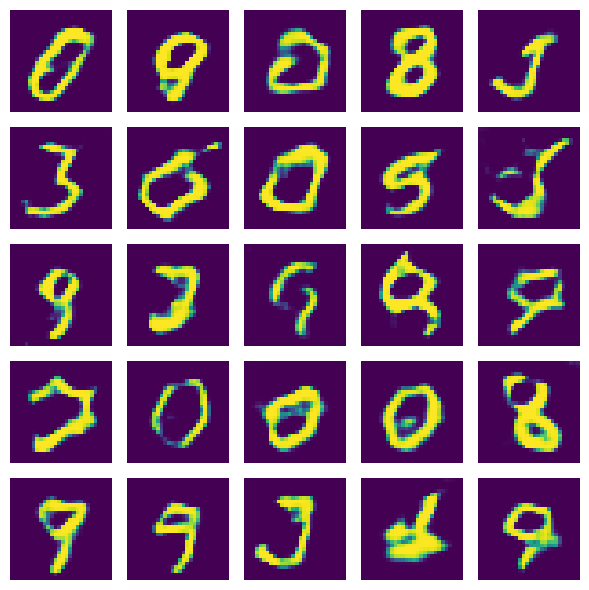

[Epoch 11/30] [Batch 99/938] [D loss: 0.660] [G loss: 0.347] (Adv: 0.909, Dec: 0.285) [Bit acc: 0.883] [Full rec: 0.094]
[Epoch 11/30] [Batch 199/938] [D loss: 0.850] [G loss: 0.399] (Adv: 1.516, Dec: 0.275) [Bit acc: 0.879] [Full rec: 0.172]
[Epoch 11/30] [Batch 299/938] [D loss: 0.734] [G loss: 0.392] (Adv: 1.249, Dec: 0.297) [Bit acc: 0.866] [Full rec: 0.078]
[Epoch 11/30] [Batch 399/938] [D loss: 0.626] [G loss: 0.376] (Adv: 1.559, Dec: 0.244) [Bit acc: 0.902] [Full rec: 0.125]
[Epoch 11/30] [Batch 499/938] [D loss: 0.882] [G loss: 0.337] (Adv: 1.267, Dec: 0.234) [Bit acc: 0.899] [Full rec: 0.172]
[Epoch 11/30] [Batch 599/938] [D loss: 0.852] [G loss: 0.390] (Adv: 1.576, Dec: 0.259) [Bit acc: 0.890] [Full rec: 0.125]
[Epoch 11/30] [Batch 699/938] [D loss: 0.850] [G loss: 0.326] (Adv: 1.499, Dec: 0.196) [Bit acc: 0.928] [Full rec: 0.250]
[Epoch 11/30] [Batch 799/938] [D loss: 0.667] [G loss: 0.316] (Adv: 1.280, Dec: 0.208) [Bit acc: 0.920] [Full rec: 0.281]
[Epoch 11/30] [Batch 899/

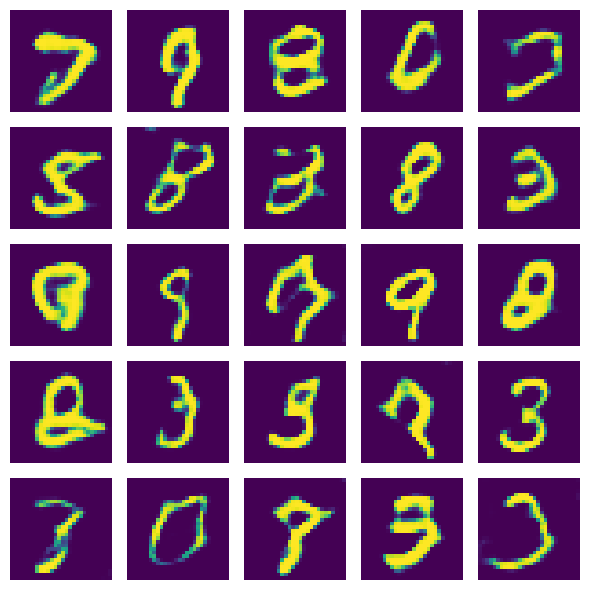

[Epoch 12/30] [Batch 99/938] [D loss: 0.760] [G loss: 0.306] (Adv: 1.204, Dec: 0.206) [Bit acc: 0.914] [Full rec: 0.234]
[Epoch 12/30] [Batch 199/938] [D loss: 0.821] [G loss: 0.320] (Adv: 1.345, Dec: 0.206) [Bit acc: 0.910] [Full rec: 0.188]
[Epoch 12/30] [Batch 299/938] [D loss: 0.775] [G loss: 0.339] (Adv: 1.617, Dec: 0.197) [Bit acc: 0.920] [Full rec: 0.250]
[Epoch 12/30] [Batch 399/938] [D loss: 0.544] [G loss: 0.311] (Adv: 1.379, Dec: 0.192) [Bit acc: 0.914] [Full rec: 0.281]
[Epoch 12/30] [Batch 499/938] [D loss: 0.563] [G loss: 0.280] (Adv: 1.171, Dec: 0.181) [Bit acc: 0.928] [Full rec: 0.266]
[Epoch 12/30] [Batch 599/938] [D loss: 0.723] [G loss: 0.281] (Adv: 1.298, Dec: 0.168) [Bit acc: 0.932] [Full rec: 0.281]
[Epoch 12/30] [Batch 699/938] [D loss: 0.774] [G loss: 0.291] (Adv: 1.316, Dec: 0.177) [Bit acc: 0.929] [Full rec: 0.312]
[Epoch 12/30] [Batch 799/938] [D loss: 0.843] [G loss: 0.225] (Adv: 0.775, Dec: 0.164) [Bit acc: 0.935] [Full rec: 0.391]
[Epoch 12/30] [Batch 899/

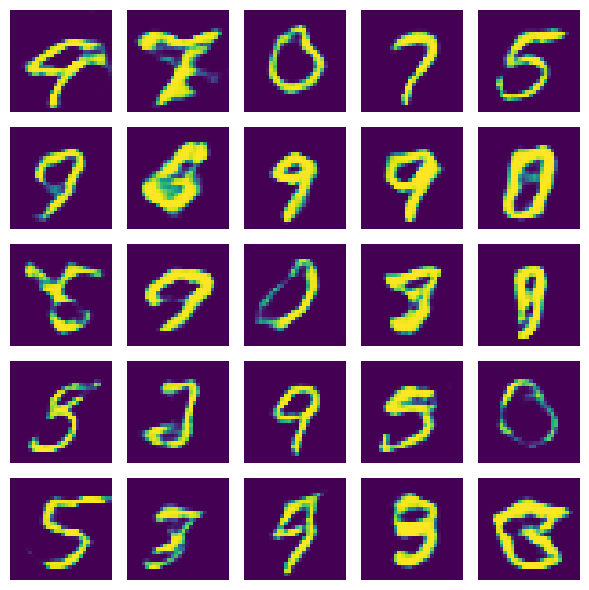

[Epoch 13/30] [Batch 99/938] [D loss: 0.496] [G loss: 0.327] (Adv: 1.777, Dec: 0.166) [Bit acc: 0.933] [Full rec: 0.297]
[Epoch 13/30] [Batch 199/938] [D loss: 0.590] [G loss: 0.241] (Adv: 1.084, Dec: 0.148) [Bit acc: 0.941] [Full rec: 0.453]
[Epoch 13/30] [Batch 299/938] [D loss: 0.612] [G loss: 0.244] (Adv: 1.233, Dec: 0.134) [Bit acc: 0.948] [Full rec: 0.406]
[Epoch 13/30] [Batch 399/938] [D loss: 0.637] [G loss: 0.283] (Adv: 1.392, Dec: 0.160) [Bit acc: 0.939] [Full rec: 0.375]
[Epoch 13/30] [Batch 499/938] [D loss: 0.896] [G loss: 0.251] (Adv: 1.313, Dec: 0.133) [Bit acc: 0.939] [Full rec: 0.391]
[Epoch 13/30] [Batch 599/938] [D loss: 0.633] [G loss: 0.198] (Adv: 0.663, Dec: 0.146) [Bit acc: 0.942] [Full rec: 0.422]
[Epoch 13/30] [Batch 699/938] [D loss: 1.051] [G loss: 0.294] (Adv: 1.656, Dec: 0.143) [Bit acc: 0.945] [Full rec: 0.422]
[Epoch 13/30] [Batch 799/938] [D loss: 0.601] [G loss: 0.243] (Adv: 1.064, Dec: 0.152) [Bit acc: 0.952] [Full rec: 0.438]
[Epoch 13/30] [Batch 899/

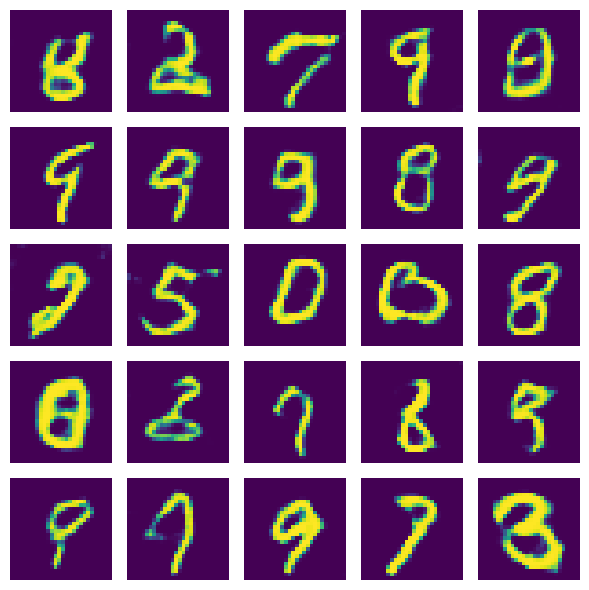

[Epoch 14/30] [Batch 99/938] [D loss: 0.746] [G loss: 0.242] (Adv: 1.288, Dec: 0.126) [Bit acc: 0.954] [Full rec: 0.484]
[Epoch 14/30] [Batch 199/938] [D loss: 0.850] [G loss: 0.266] (Adv: 1.440, Dec: 0.136) [Bit acc: 0.944] [Full rec: 0.406]
[Epoch 14/30] [Batch 299/938] [D loss: 0.668] [G loss: 0.229] (Adv: 1.248, Dec: 0.116) [Bit acc: 0.952] [Full rec: 0.469]
[Epoch 14/30] [Batch 399/938] [D loss: 0.553] [G loss: 0.208] (Adv: 1.100, Dec: 0.109) [Bit acc: 0.957] [Full rec: 0.531]
[Epoch 14/30] [Batch 499/938] [D loss: 0.699] [G loss: 0.280] (Adv: 1.464, Dec: 0.148) [Bit acc: 0.946] [Full rec: 0.391]
[Epoch 14/30] [Batch 599/938] [D loss: 0.778] [G loss: 0.256] (Adv: 1.480, Dec: 0.120) [Bit acc: 0.948] [Full rec: 0.438]
[Epoch 14/30] [Batch 699/938] [D loss: 0.586] [G loss: 0.238] (Adv: 1.274, Dec: 0.123) [Bit acc: 0.955] [Full rec: 0.469]
[Epoch 14/30] [Batch 799/938] [D loss: 0.484] [G loss: 0.210] (Adv: 1.148, Dec: 0.105) [Bit acc: 0.962] [Full rec: 0.516]
[Epoch 14/30] [Batch 899/

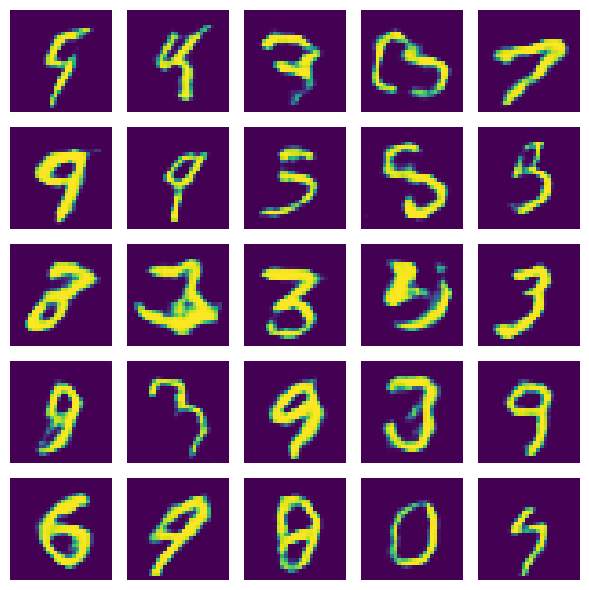

[Epoch 15/30] [Batch 99/938] [D loss: 0.677] [G loss: 0.238] (Adv: 1.417, Dec: 0.107) [Bit acc: 0.962] [Full rec: 0.516]
[Epoch 15/30] [Batch 199/938] [D loss: 0.633] [G loss: 0.247] (Adv: 1.568, Dec: 0.100) [Bit acc: 0.966] [Full rec: 0.562]
[Epoch 15/30] [Batch 299/938] [D loss: 0.793] [G loss: 0.178] (Adv: 0.783, Dec: 0.110) [Bit acc: 0.961] [Full rec: 0.562]
[Epoch 15/30] [Batch 399/938] [D loss: 0.736] [G loss: 0.194] (Adv: 1.006, Dec: 0.104) [Bit acc: 0.951] [Full rec: 0.484]
[Epoch 15/30] [Batch 499/938] [D loss: 0.590] [G loss: 0.231] (Adv: 1.251, Dec: 0.118) [Bit acc: 0.958] [Full rec: 0.500]
[Epoch 15/30] [Batch 599/938] [D loss: 0.753] [G loss: 0.219] (Adv: 1.229, Dec: 0.107) [Bit acc: 0.957] [Full rec: 0.469]
[Epoch 15/30] [Batch 699/938] [D loss: 0.808] [G loss: 0.179] (Adv: 0.990, Dec: 0.089) [Bit acc: 0.958] [Full rec: 0.500]
[Epoch 15/30] [Batch 799/938] [D loss: 0.876] [G loss: 0.236] (Adv: 1.473, Dec: 0.099) [Bit acc: 0.968] [Full rec: 0.625]
[Epoch 15/30] [Batch 899/

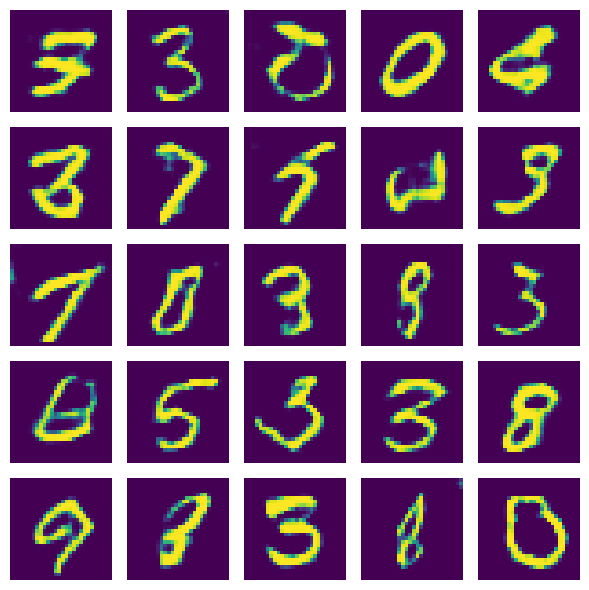

[Epoch 16/30] [Batch 99/938] [D loss: 0.833] [G loss: 0.231] (Adv: 1.596, Dec: 0.079) [Bit acc: 0.962] [Full rec: 0.500]
[Epoch 16/30] [Batch 199/938] [D loss: 0.834] [G loss: 0.193] (Adv: 1.293, Dec: 0.071) [Bit acc: 0.973] [Full rec: 0.703]
[Epoch 16/30] [Batch 299/938] [D loss: 0.671] [G loss: 0.210] (Adv: 1.321, Dec: 0.086) [Bit acc: 0.965] [Full rec: 0.562]
[Epoch 16/30] [Batch 399/938] [D loss: 0.765] [G loss: 0.198] (Adv: 1.113, Dec: 0.096) [Bit acc: 0.959] [Full rec: 0.422]
[Epoch 16/30] [Batch 499/938] [D loss: 0.992] [G loss: 0.279] (Adv: 2.007, Dec: 0.087) [Bit acc: 0.969] [Full rec: 0.609]
[Epoch 16/30] [Batch 599/938] [D loss: 0.622] [G loss: 0.239] (Adv: 1.509, Dec: 0.097) [Bit acc: 0.960] [Full rec: 0.516]
[Epoch 16/30] [Batch 699/938] [D loss: 0.736] [G loss: 0.216] (Adv: 1.412, Dec: 0.083) [Bit acc: 0.966] [Full rec: 0.547]
[Epoch 16/30] [Batch 799/938] [D loss: 0.834] [G loss: 0.220] (Adv: 1.383, Dec: 0.091) [Bit acc: 0.967] [Full rec: 0.547]
[Epoch 16/30] [Batch 899/

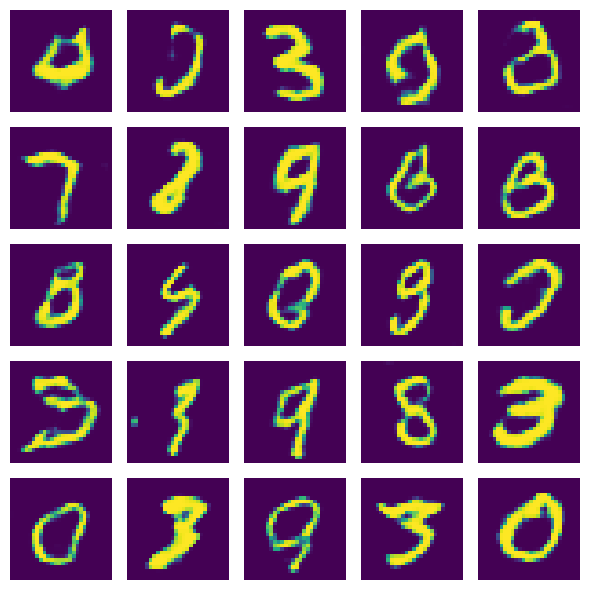

[Epoch 17/30] [Batch 99/938] [D loss: 0.892] [G loss: 0.152] (Adv: 0.929, Dec: 0.065) [Bit acc: 0.972] [Full rec: 0.625]
[Epoch 17/30] [Batch 199/938] [D loss: 0.942] [G loss: 0.142] (Adv: 0.884, Dec: 0.060) [Bit acc: 0.978] [Full rec: 0.703]
[Epoch 17/30] [Batch 299/938] [D loss: 0.797] [G loss: 0.215] (Adv: 1.200, Dec: 0.105) [Bit acc: 0.961] [Full rec: 0.484]
[Epoch 17/30] [Batch 399/938] [D loss: 0.920] [G loss: 0.151] (Adv: 0.870, Dec: 0.071) [Bit acc: 0.975] [Full rec: 0.688]
[Epoch 17/30] [Batch 499/938] [D loss: 0.786] [G loss: 0.140] (Adv: 0.825, Dec: 0.064) [Bit acc: 0.977] [Full rec: 0.688]
[Epoch 17/30] [Batch 599/938] [D loss: 0.961] [G loss: 0.204] (Adv: 1.285, Dec: 0.083) [Bit acc: 0.972] [Full rec: 0.641]
[Epoch 17/30] [Batch 699/938] [D loss: 0.752] [G loss: 0.195] (Adv: 1.209, Dec: 0.082) [Bit acc: 0.973] [Full rec: 0.625]
[Epoch 17/30] [Batch 799/938] [D loss: 0.819] [G loss: 0.214] (Adv: 1.439, Dec: 0.078) [Bit acc: 0.969] [Full rec: 0.625]
[Epoch 17/30] [Batch 899/

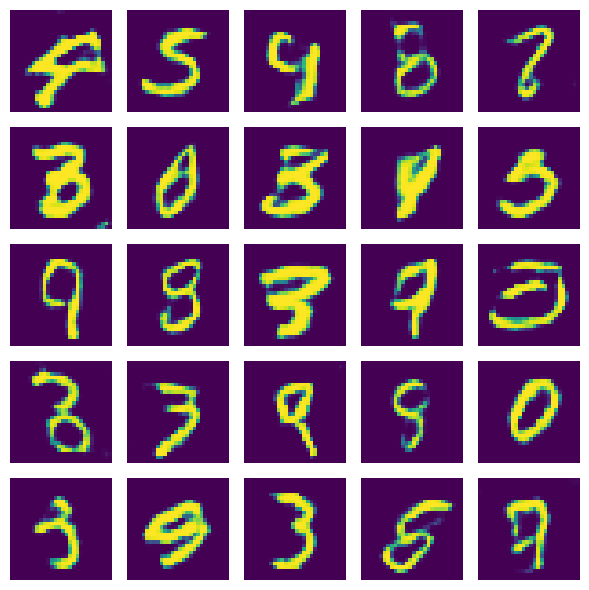

[Epoch 18/30] [Batch 99/938] [D loss: 0.745] [G loss: 0.167] (Adv: 1.160, Dec: 0.057) [Bit acc: 0.982] [Full rec: 0.781]
[Epoch 18/30] [Batch 199/938] [D loss: 0.642] [G loss: 0.265] (Adv: 1.976, Dec: 0.075) [Bit acc: 0.975] [Full rec: 0.641]
[Epoch 18/30] [Batch 299/938] [D loss: 0.926] [G loss: 0.155] (Adv: 1.089, Dec: 0.051) [Bit acc: 0.981] [Full rec: 0.766]
[Epoch 18/30] [Batch 399/938] [D loss: 0.698] [G loss: 0.229] (Adv: 1.478, Dec: 0.090) [Bit acc: 0.965] [Full rec: 0.609]
[Epoch 18/30] [Batch 499/938] [D loss: 0.888] [G loss: 0.192] (Adv: 1.347, Dec: 0.064) [Bit acc: 0.979] [Full rec: 0.688]
[Epoch 18/30] [Batch 599/938] [D loss: 0.820] [G loss: 0.162] (Adv: 1.062, Dec: 0.063) [Bit acc: 0.979] [Full rec: 0.734]
[Epoch 18/30] [Batch 699/938] [D loss: 0.852] [G loss: 0.165] (Adv: 0.919, Dec: 0.081) [Bit acc: 0.970] [Full rec: 0.609]
[Epoch 18/30] [Batch 799/938] [D loss: 0.904] [G loss: 0.178] (Adv: 1.047, Dec: 0.081) [Bit acc: 0.965] [Full rec: 0.547]
[Epoch 18/30] [Batch 899/

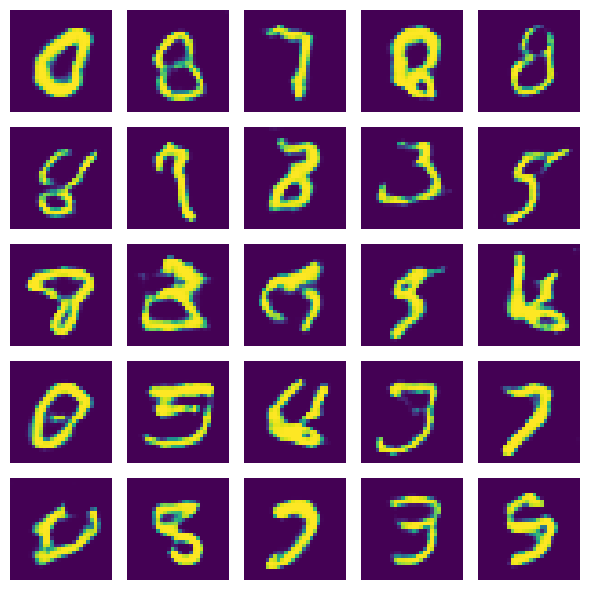

[Epoch 19/30] [Batch 99/938] [D loss: 0.869] [G loss: 0.185] (Adv: 1.108, Dec: 0.082) [Bit acc: 0.972] [Full rec: 0.641]
[Epoch 19/30] [Batch 199/938] [D loss: 0.905] [G loss: 0.174] (Adv: 1.088, Dec: 0.072) [Bit acc: 0.974] [Full rec: 0.672]
[Epoch 19/30] [Batch 299/938] [D loss: 0.671] [G loss: 0.165] (Adv: 1.217, Dec: 0.048) [Bit acc: 0.979] [Full rec: 0.703]
[Epoch 19/30] [Batch 399/938] [D loss: 0.850] [G loss: 0.198] (Adv: 1.431, Dec: 0.061) [Bit acc: 0.978] [Full rec: 0.703]
[Epoch 19/30] [Batch 499/938] [D loss: 0.845] [G loss: 0.202] (Adv: 1.336, Dec: 0.076) [Bit acc: 0.964] [Full rec: 0.547]
[Epoch 19/30] [Batch 599/938] [D loss: 0.998] [G loss: 0.160] (Adv: 1.027, Dec: 0.064) [Bit acc: 0.975] [Full rec: 0.688]
[Epoch 19/30] [Batch 699/938] [D loss: 0.792] [G loss: 0.169] (Adv: 1.098, Dec: 0.066) [Bit acc: 0.975] [Full rec: 0.641]
[Epoch 19/30] [Batch 799/938] [D loss: 0.821] [G loss: 0.140] (Adv: 0.890, Dec: 0.057) [Bit acc: 0.974] [Full rec: 0.688]
[Epoch 19/30] [Batch 899/

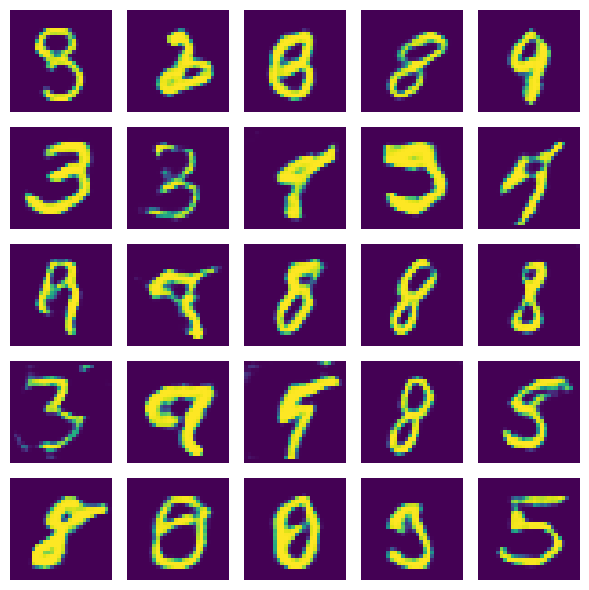

[Epoch 20/30] [Batch 99/938] [D loss: 0.741] [G loss: 0.155] (Adv: 1.043, Dec: 0.056) [Bit acc: 0.980] [Full rec: 0.719]
[Epoch 20/30] [Batch 199/938] [D loss: 0.920] [G loss: 0.196] (Adv: 1.413, Dec: 0.061) [Bit acc: 0.977] [Full rec: 0.719]
[Epoch 20/30] [Batch 299/938] [D loss: 0.785] [G loss: 0.216] (Adv: 1.626, Dec: 0.059) [Bit acc: 0.978] [Full rec: 0.672]
[Epoch 20/30] [Batch 399/938] [D loss: 0.796] [G loss: 0.163] (Adv: 1.091, Dec: 0.060) [Bit acc: 0.977] [Full rec: 0.719]
[Epoch 20/30] [Batch 499/938] [D loss: 0.683] [G loss: 0.204] (Adv: 1.540, Dec: 0.055) [Bit acc: 0.979] [Full rec: 0.719]
[Epoch 20/30] [Batch 599/938] [D loss: 0.733] [G loss: 0.190] (Adv: 1.379, Dec: 0.058) [Bit acc: 0.977] [Full rec: 0.719]
[Epoch 20/30] [Batch 699/938] [D loss: 0.925] [G loss: 0.199] (Adv: 1.531, Dec: 0.051) [Bit acc: 0.983] [Full rec: 0.766]
[Epoch 20/30] [Batch 799/938] [D loss: 0.753] [G loss: 0.134] (Adv: 0.916, Dec: 0.047) [Bit acc: 0.982] [Full rec: 0.750]
[Epoch 20/30] [Batch 899/

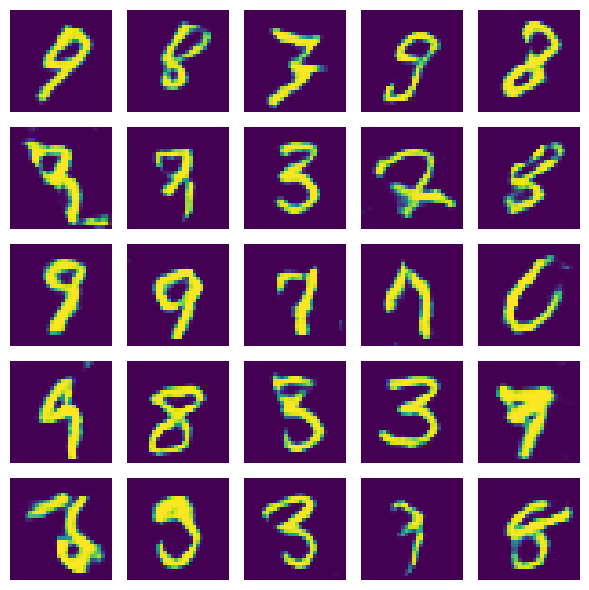

[Epoch 21/30] [Batch 99/938] [D loss: 0.918] [G loss: 0.144] (Adv: 0.944, Dec: 0.056) [Bit acc: 0.983] [Full rec: 0.812]
[Epoch 21/30] [Batch 199/938] [D loss: 0.794] [G loss: 0.121] (Adv: 0.806, Dec: 0.045) [Bit acc: 0.983] [Full rec: 0.797]
[Epoch 21/30] [Batch 299/938] [D loss: 0.906] [G loss: 0.170] (Adv: 1.295, Dec: 0.045) [Bit acc: 0.982] [Full rec: 0.734]
[Epoch 21/30] [Batch 399/938] [D loss: 0.753] [G loss: 0.158] (Adv: 1.004, Dec: 0.064) [Bit acc: 0.978] [Full rec: 0.672]
[Epoch 21/30] [Batch 499/938] [D loss: 0.964] [G loss: 0.170] (Adv: 1.363, Dec: 0.038) [Bit acc: 0.985] [Full rec: 0.781]
[Epoch 21/30] [Batch 599/938] [D loss: 0.944] [G loss: 0.132] (Adv: 0.855, Dec: 0.052) [Bit acc: 0.979] [Full rec: 0.719]
[Epoch 21/30] [Batch 699/938] [D loss: 0.811] [G loss: 0.152] (Adv: 1.012, Dec: 0.056) [Bit acc: 0.979] [Full rec: 0.688]
[Epoch 21/30] [Batch 799/938] [D loss: 0.888] [G loss: 0.180] (Adv: 1.375, Dec: 0.048) [Bit acc: 0.981] [Full rec: 0.703]
[Epoch 21/30] [Batch 899/

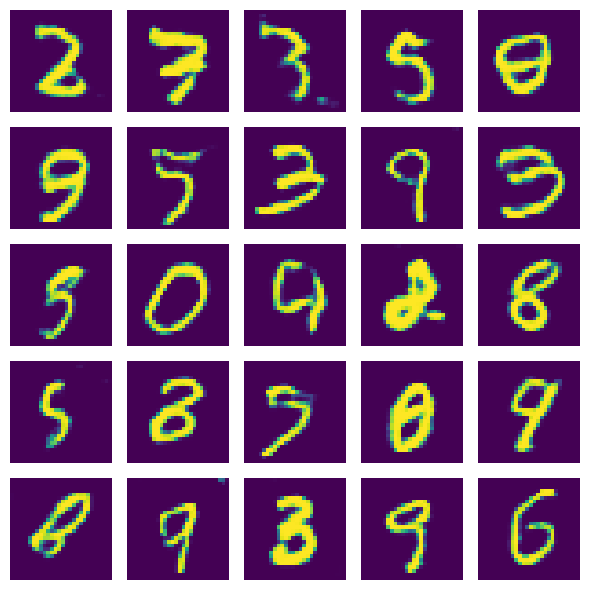

[Epoch 22/30] [Batch 99/938] [D loss: 0.828] [G loss: 0.222] (Adv: 1.743, Dec: 0.053) [Bit acc: 0.982] [Full rec: 0.766]
[Epoch 22/30] [Batch 199/938] [D loss: 0.707] [G loss: 0.172] (Adv: 1.289, Dec: 0.048) [Bit acc: 0.985] [Full rec: 0.766]
[Epoch 22/30] [Batch 299/938] [D loss: 0.746] [G loss: 0.109] (Adv: 0.743, Dec: 0.038) [Bit acc: 0.985] [Full rec: 0.781]
[Epoch 22/30] [Batch 399/938] [D loss: 0.879] [G loss: 0.138] (Adv: 0.971, Dec: 0.045) [Bit acc: 0.985] [Full rec: 0.797]
[Epoch 22/30] [Batch 499/938] [D loss: 1.166] [G loss: 0.161] (Adv: 1.218, Dec: 0.043) [Bit acc: 0.985] [Full rec: 0.766]
[Epoch 22/30] [Batch 599/938] [D loss: 0.650] [G loss: 0.163] (Adv: 1.083, Dec: 0.061) [Bit acc: 0.978] [Full rec: 0.703]
[Epoch 22/30] [Batch 699/938] [D loss: 0.828] [G loss: 0.153] (Adv: 1.264, Dec: 0.029) [Bit acc: 0.991] [Full rec: 0.875]
[Epoch 22/30] [Batch 799/938] [D loss: 0.795] [G loss: 0.131] (Adv: 0.923, Dec: 0.043) [Bit acc: 0.982] [Full rec: 0.750]
[Epoch 22/30] [Batch 899/

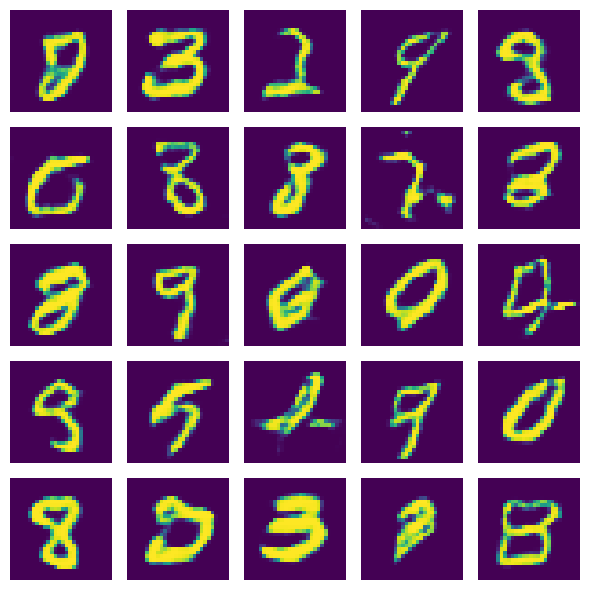

[Epoch 23/30] [Batch 99/938] [D loss: 0.837] [G loss: 0.159] (Adv: 1.111, Dec: 0.053) [Bit acc: 0.979] [Full rec: 0.703]
[Epoch 23/30] [Batch 199/938] [D loss: 0.942] [G loss: 0.142] (Adv: 1.035, Dec: 0.043) [Bit acc: 0.988] [Full rec: 0.812]
[Epoch 23/30] [Batch 299/938] [D loss: 0.753] [G loss: 0.122] (Adv: 0.834, Dec: 0.043) [Bit acc: 0.986] [Full rec: 0.812]
[Epoch 23/30] [Batch 399/938] [D loss: 1.040] [G loss: 0.166] (Adv: 1.013, Dec: 0.072) [Bit acc: 0.978] [Full rec: 0.688]
[Epoch 23/30] [Batch 499/938] [D loss: 0.745] [G loss: 0.175] (Adv: 1.399, Dec: 0.039) [Bit acc: 0.986] [Full rec: 0.812]
[Epoch 23/30] [Batch 599/938] [D loss: 0.919] [G loss: 0.155] (Adv: 1.237, Dec: 0.035) [Bit acc: 0.987] [Full rec: 0.797]
[Epoch 23/30] [Batch 699/938] [D loss: 0.758] [G loss: 0.137] (Adv: 1.009, Dec: 0.040) [Bit acc: 0.983] [Full rec: 0.781]
[Epoch 23/30] [Batch 799/938] [D loss: 0.947] [G loss: 0.154] (Adv: 1.047, Dec: 0.055) [Bit acc: 0.980] [Full rec: 0.703]
[Epoch 23/30] [Batch 899/

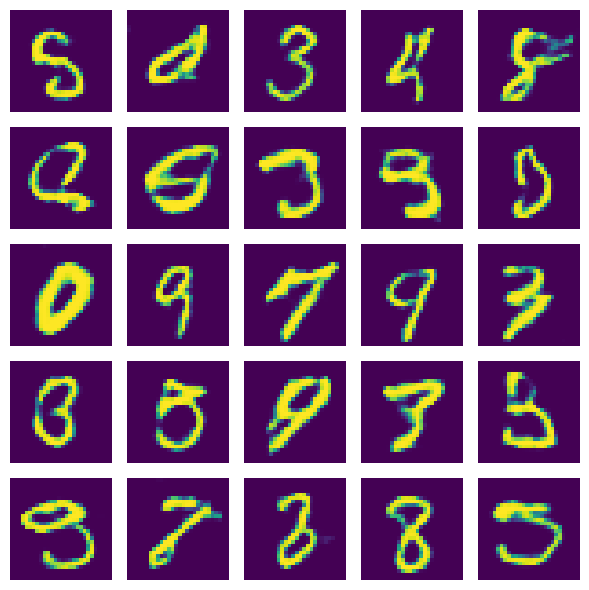

[Epoch 24/30] [Batch 99/938] [D loss: 1.120] [G loss: 0.134] (Adv: 0.966, Dec: 0.042) [Bit acc: 0.981] [Full rec: 0.719]
[Epoch 24/30] [Batch 199/938] [D loss: 0.884] [G loss: 0.133] (Adv: 0.948, Dec: 0.042) [Bit acc: 0.985] [Full rec: 0.781]
[Epoch 24/30] [Batch 299/938] [D loss: 0.792] [G loss: 0.160] (Adv: 1.229, Dec: 0.041) [Bit acc: 0.984] [Full rec: 0.750]
[Epoch 24/30] [Batch 399/938] [D loss: 0.894] [G loss: 0.133] (Adv: 0.950, Dec: 0.042) [Bit acc: 0.989] [Full rec: 0.844]
[Epoch 24/30] [Batch 499/938] [D loss: 0.783] [G loss: 0.194] (Adv: 1.436, Dec: 0.056) [Bit acc: 0.981] [Full rec: 0.734]
[Epoch 24/30] [Batch 599/938] [D loss: 0.757] [G loss: 0.131] (Adv: 1.022, Dec: 0.032) [Bit acc: 0.988] [Full rec: 0.828]
[Epoch 24/30] [Batch 699/938] [D loss: 0.921] [G loss: 0.110] (Adv: 0.857, Dec: 0.027) [Bit acc: 0.994] [Full rec: 0.906]
[Epoch 24/30] [Batch 799/938] [D loss: 0.911] [G loss: 0.156] (Adv: 1.307, Dec: 0.028) [Bit acc: 0.992] [Full rec: 0.875]
[Epoch 24/30] [Batch 899/

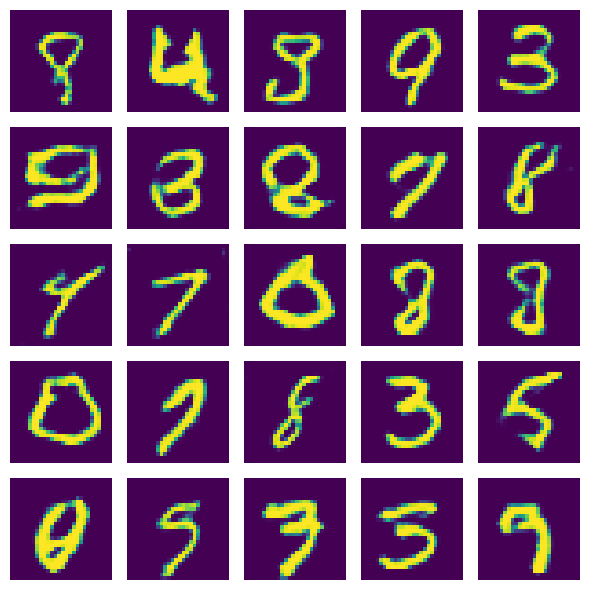

[Epoch 25/30] [Batch 99/938] [D loss: 0.863] [G loss: 0.138] (Adv: 0.916, Dec: 0.051) [Bit acc: 0.985] [Full rec: 0.797]
[Epoch 25/30] [Batch 199/938] [D loss: 0.836] [G loss: 0.145] (Adv: 1.053, Dec: 0.044) [Bit acc: 0.983] [Full rec: 0.766]
[Epoch 25/30] [Batch 299/938] [D loss: 0.871] [G loss: 0.121] (Adv: 0.916, Dec: 0.033) [Bit acc: 0.992] [Full rec: 0.875]
[Epoch 25/30] [Batch 399/938] [D loss: 0.755] [G loss: 0.152] (Adv: 1.101, Dec: 0.046) [Bit acc: 0.985] [Full rec: 0.766]
[Epoch 25/30] [Batch 499/938] [D loss: 0.898] [G loss: 0.100] (Adv: 0.647, Dec: 0.039) [Bit acc: 0.985] [Full rec: 0.797]
[Epoch 25/30] [Batch 599/938] [D loss: 0.873] [G loss: 0.124] (Adv: 0.931, Dec: 0.035) [Bit acc: 0.985] [Full rec: 0.797]
[Epoch 25/30] [Batch 699/938] [D loss: 0.831] [G loss: 0.151] (Adv: 1.208, Dec: 0.034) [Bit acc: 0.989] [Full rec: 0.828]
[Epoch 25/30] [Batch 799/938] [D loss: 1.095] [G loss: 0.146] (Adv: 0.877, Dec: 0.065) [Bit acc: 0.976] [Full rec: 0.656]
[Epoch 25/30] [Batch 899/

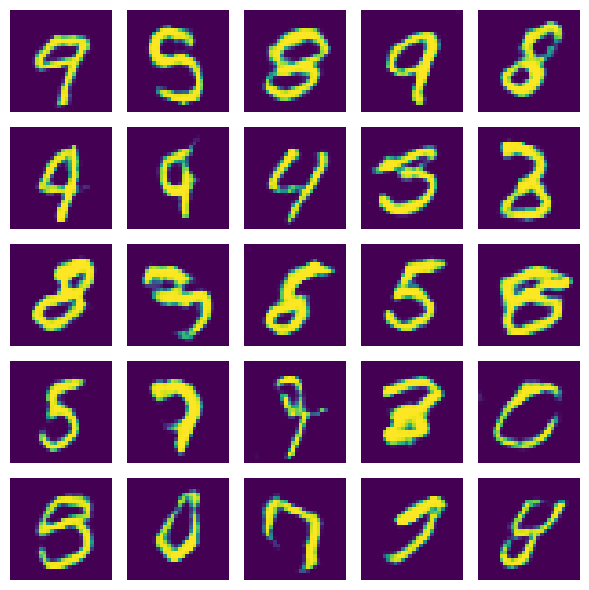

[Epoch 26/30] [Batch 99/938] [D loss: 0.902] [G loss: 0.128] (Adv: 1.016, Dec: 0.030) [Bit acc: 0.988] [Full rec: 0.812]
[Epoch 26/30] [Batch 199/938] [D loss: 1.090] [G loss: 0.091] (Adv: 0.594, Dec: 0.035) [Bit acc: 0.987] [Full rec: 0.812]
[Epoch 26/30] [Batch 299/938] [D loss: 0.998] [G loss: 0.135] (Adv: 0.998, Dec: 0.039) [Bit acc: 0.985] [Full rec: 0.797]
[Epoch 26/30] [Batch 399/938] [D loss: 0.794] [G loss: 0.158] (Adv: 1.117, Dec: 0.051) [Bit acc: 0.982] [Full rec: 0.750]
[Epoch 26/30] [Batch 499/938] [D loss: 0.881] [G loss: 0.158] (Adv: 1.265, Dec: 0.035) [Bit acc: 0.986] [Full rec: 0.812]
[Epoch 26/30] [Batch 599/938] [D loss: 0.778] [G loss: 0.165] (Adv: 1.250, Dec: 0.045) [Bit acc: 0.988] [Full rec: 0.828]
[Epoch 26/30] [Batch 699/938] [D loss: 0.991] [G loss: 0.132] (Adv: 0.928, Dec: 0.043) [Bit acc: 0.981] [Full rec: 0.766]
[Epoch 26/30] [Batch 799/938] [D loss: 0.906] [G loss: 0.133] (Adv: 1.005, Dec: 0.036) [Bit acc: 0.986] [Full rec: 0.781]
[Epoch 26/30] [Batch 899/

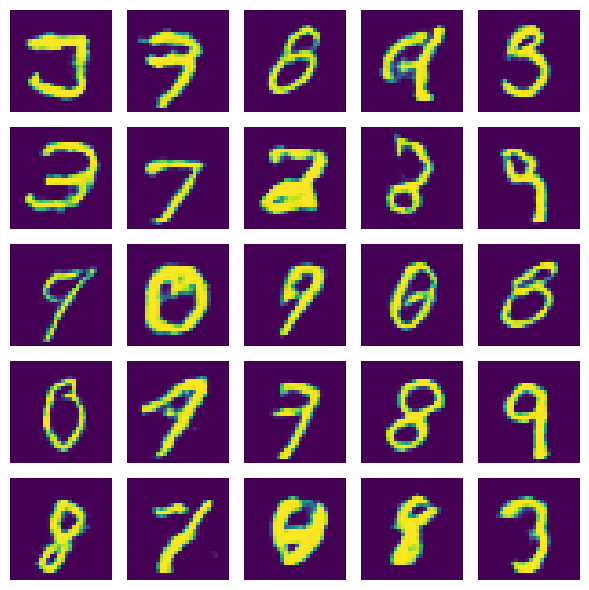

[Epoch 27/30] [Batch 99/938] [D loss: 0.812] [G loss: 0.125] (Adv: 1.007, Dec: 0.027) [Bit acc: 0.990] [Full rec: 0.859]
[Epoch 27/30] [Batch 199/938] [D loss: 0.714] [G loss: 0.161] (Adv: 1.167, Dec: 0.049) [Bit acc: 0.982] [Full rec: 0.750]
[Epoch 27/30] [Batch 299/938] [D loss: 0.980] [G loss: 0.168] (Adv: 1.452, Dec: 0.025) [Bit acc: 0.992] [Full rec: 0.875]
[Epoch 27/30] [Batch 399/938] [D loss: 1.130] [G loss: 0.154] (Adv: 1.218, Dec: 0.036) [Bit acc: 0.984] [Full rec: 0.766]
[Epoch 27/30] [Batch 499/938] [D loss: 0.856] [G loss: 0.131] (Adv: 0.910, Dec: 0.045) [Bit acc: 0.981] [Full rec: 0.766]
[Epoch 27/30] [Batch 599/938] [D loss: 1.106] [G loss: 0.155] (Adv: 1.174, Dec: 0.042) [Bit acc: 0.982] [Full rec: 0.781]
[Epoch 27/30] [Batch 699/938] [D loss: 0.540] [G loss: 0.088] (Adv: 0.546, Dec: 0.037) [Bit acc: 0.984] [Full rec: 0.750]
[Epoch 27/30] [Batch 799/938] [D loss: 0.955] [G loss: 0.141] (Adv: 0.983, Dec: 0.047) [Bit acc: 0.981] [Full rec: 0.766]
[Epoch 27/30] [Batch 899/

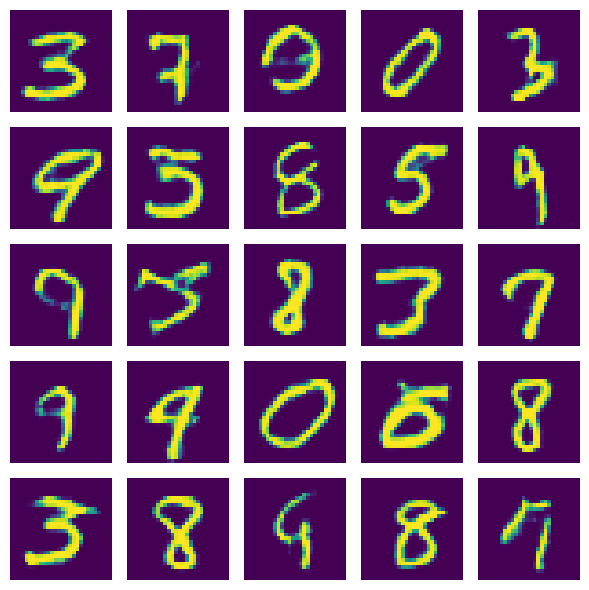

[Epoch 28/30] [Batch 99/938] [D loss: 0.974] [G loss: 0.129] (Adv: 0.918, Dec: 0.042) [Bit acc: 0.985] [Full rec: 0.766]
[Epoch 28/30] [Batch 199/938] [D loss: 1.026] [G loss: 0.124] (Adv: 0.973, Dec: 0.030) [Bit acc: 0.990] [Full rec: 0.859]
[Epoch 28/30] [Batch 299/938] [D loss: 0.930] [G loss: 0.192] (Adv: 1.561, Dec: 0.040) [Bit acc: 0.985] [Full rec: 0.781]
[Epoch 28/30] [Batch 399/938] [D loss: 0.783] [G loss: 0.140] (Adv: 0.995, Dec: 0.045) [Bit acc: 0.981] [Full rec: 0.750]
[Epoch 28/30] [Batch 499/938] [D loss: 1.135] [G loss: 0.152] (Adv: 1.202, Dec: 0.035) [Bit acc: 0.988] [Full rec: 0.844]
[Epoch 28/30] [Batch 599/938] [D loss: 1.063] [G loss: 0.116] (Adv: 0.807, Dec: 0.039) [Bit acc: 0.985] [Full rec: 0.781]
[Epoch 28/30] [Batch 699/938] [D loss: 1.024] [G loss: 0.149] (Adv: 1.280, Dec: 0.024) [Bit acc: 0.991] [Full rec: 0.875]
[Epoch 28/30] [Batch 799/938] [D loss: 0.756] [G loss: 0.135] (Adv: 1.135, Dec: 0.024) [Bit acc: 0.991] [Full rec: 0.859]
[Epoch 28/30] [Batch 899/

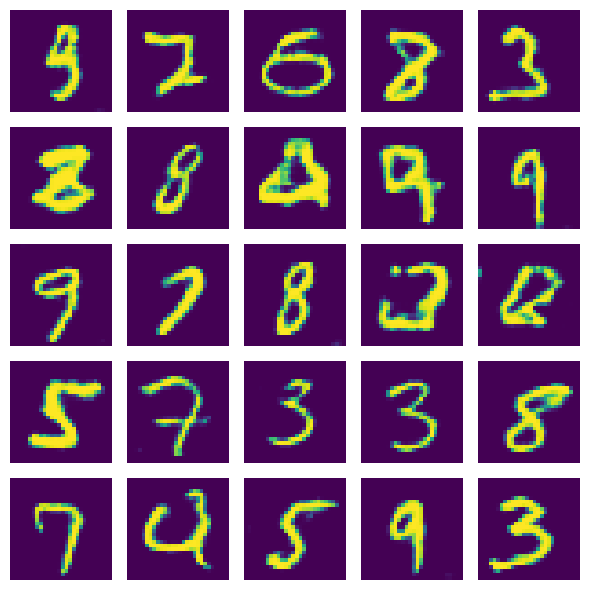

[Epoch 29/30] [Batch 99/938] [D loss: 0.885] [G loss: 0.161] (Adv: 1.147, Dec: 0.052) [Bit acc: 0.980] [Full rec: 0.766]
[Epoch 29/30] [Batch 199/938] [D loss: 1.024] [G loss: 0.147] (Adv: 1.200, Dec: 0.030) [Bit acc: 0.987] [Full rec: 0.828]
[Epoch 29/30] [Batch 299/938] [D loss: 0.908] [G loss: 0.110] (Adv: 0.878, Dec: 0.025) [Bit acc: 0.993] [Full rec: 0.891]
[Epoch 29/30] [Batch 399/938] [D loss: 0.804] [G loss: 0.119] (Adv: 0.955, Dec: 0.026) [Bit acc: 0.988] [Full rec: 0.828]
[Epoch 29/30] [Batch 499/938] [D loss: 0.924] [G loss: 0.146] (Adv: 1.097, Dec: 0.041) [Bit acc: 0.987] [Full rec: 0.797]
[Epoch 29/30] [Batch 599/938] [D loss: 0.997] [G loss: 0.154] (Adv: 1.176, Dec: 0.041) [Bit acc: 0.986] [Full rec: 0.812]
[Epoch 29/30] [Batch 699/938] [D loss: 1.229] [G loss: 0.107] (Adv: 0.688, Dec: 0.043) [Bit acc: 0.983] [Full rec: 0.750]
[Epoch 29/30] [Batch 799/938] [D loss: 0.992] [G loss: 0.134] (Adv: 1.048, Dec: 0.033) [Bit acc: 0.986] [Full rec: 0.781]
[Epoch 29/30] [Batch 899/

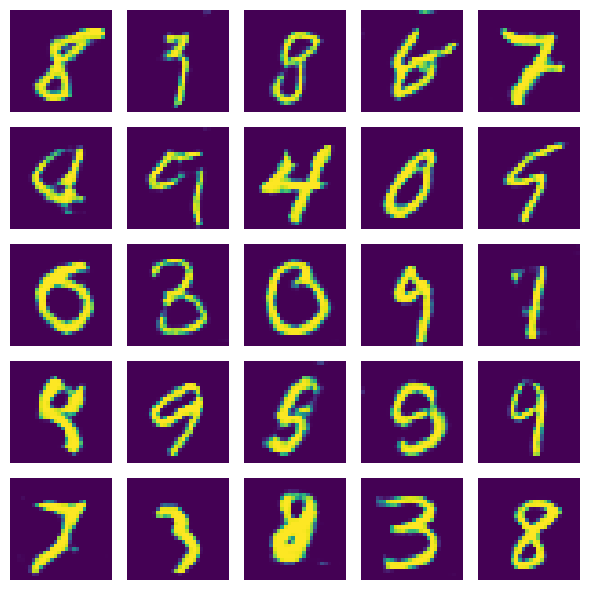

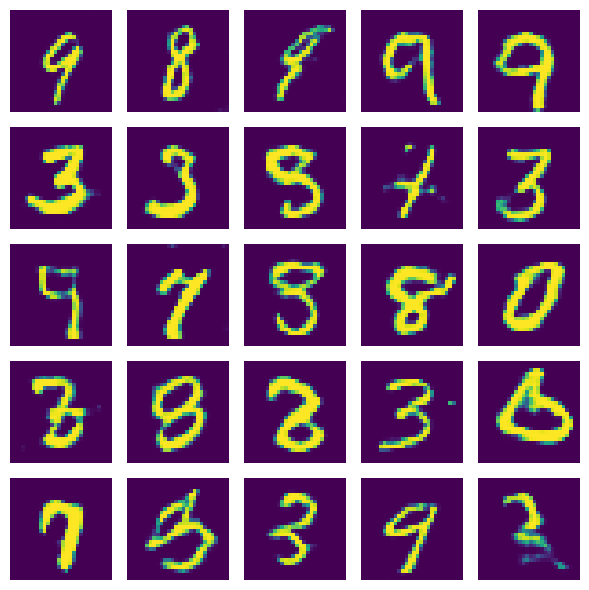

In [10]:
train()
show_samples()


In [11]:
torch.save(generator, "generator1.pth")
torch.save(discriminator, "discriminator1.pth")
torch.save(decoder, "decoder1.pth")

In [76]:
#!pip install torchmetrics[image]
!python -m pip install torch-fidelity

Defaulting to user installation because normal site-packages is not writeable


In [13]:
from torch.nn import functional as F
import torch_fidelity
from torchmetrics.image.fid import FrechetInceptionDistance

NUM_SAMPLES = 10000        
BATCH = 128                
INCEPTION_SIZE = 299

# Normalize and interpolate images to 299x299 
def prep_for_fid(x):
    x = (x + 1) * 0.5
    x = x.clamp(0, 1)
    
    # 3 channels
    if SINGLE_CHANNEL:
        x = x.repeat(1, 3, 1, 1)
    x = F.interpolate(x, size=(INCEPTION_SIZE, INCEPTION_SIZE), mode="bilinear", align_corners=False)
    return x

# Compute FID
generator.eval()
fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
torch.set_grad_enabled(False)

# Train FID on real images
for imgs, _ in dataloader:
    imgs = prep_for_fid(imgs.to(device))
    fid.update(imgs, real=True)

# Compare FID statistics to fake (generated) images
for _ in range(NUM_SAMPLES // BATCH):
    z = torch.randn(BATCH, LATENT_DIM, device=device)
    msgs = torch.randint(0, 2, (BATCH, MESSAGE_WIDTH), device=device, dtype=torch.float)
    fake = prep_for_fid(generator(z, msgs))
    fid.update(fake, real=False)

score = fid.compute().item()
print(f"FID: {score:.3f}")

FID: 14.306


In [43]:
generator = torch.load("generator1.pth", weights_only=False)
discriminator = torch.load("discriminator1.pth", weights_only=False)
decoder = torch.load("decoder1.pth", weights_only=False)

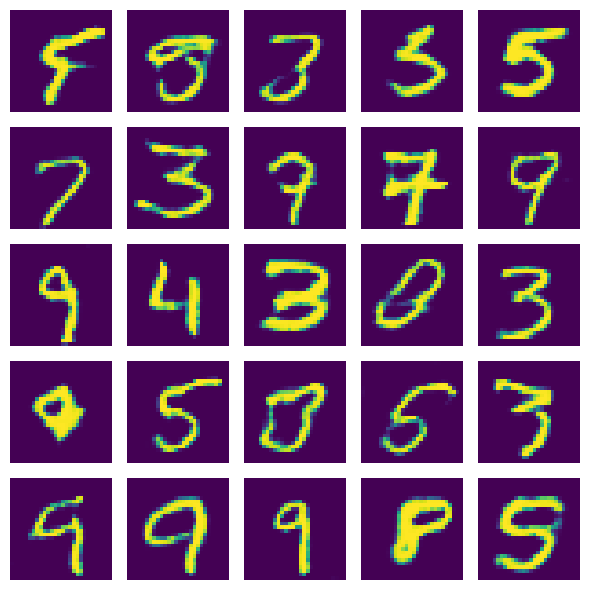

In [14]:
with torch.no_grad():
    msg = torch.randint(0, 2, (25, MESSAGE_WIDTH), device=device, dtype=torch.float)
    z_sample = torch.randn(1, LATENT_DIM, device=device)
    z = z_sample.repeat(25, 1)
    samples = generator(z, msg).cpu()
    grid = np.transpose((samples + 1) / 2, (0, 2, 3, 1))

fig, axes = plt.subplots(5, 5, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(grid[i])
    ax.axis("off")
plt.tight_layout()
plt.show()

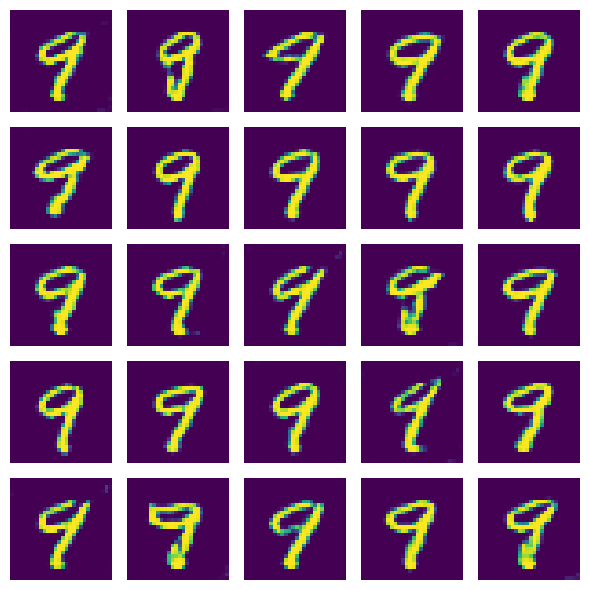

In [15]:
with torch.no_grad():
    msg_sample = torch.randint(0, 2, (1, MESSAGE_WIDTH), dtype=torch.float32, device=device)
    msg = msg_sample.repeat(25, 1)  # constant message
    z = torch.randn(25, LATENT_DIM, device=device)  # vary z
    samples = generator(z, msg).cpu()
    grid = np.transpose((samples + 1) / 2, (0, 2, 3, 1))

fig, axes = plt.subplots(5, 5, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(grid[i])
    ax.axis("off")
plt.tight_layout()
plt.show()


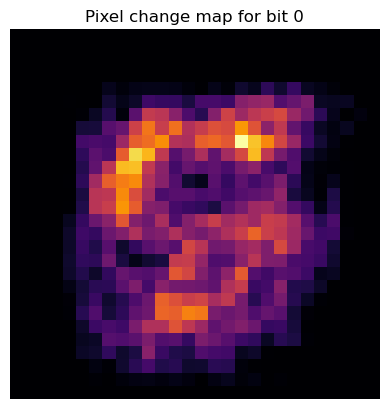

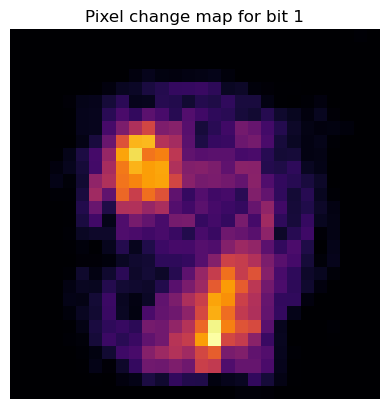

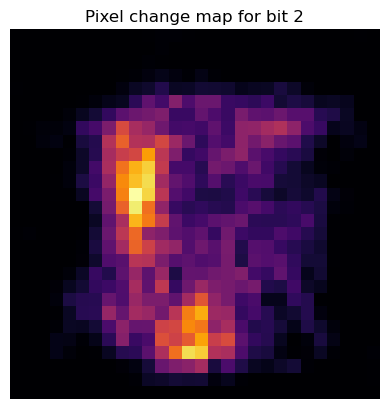

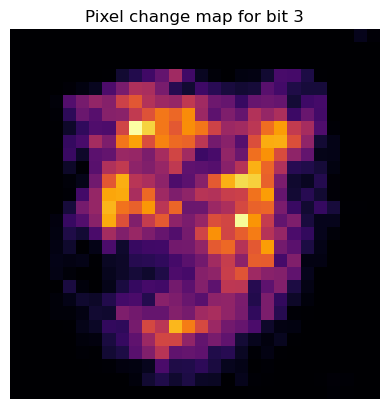

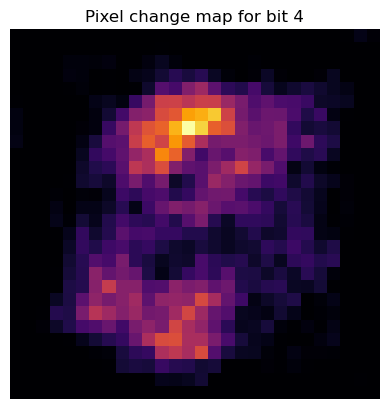

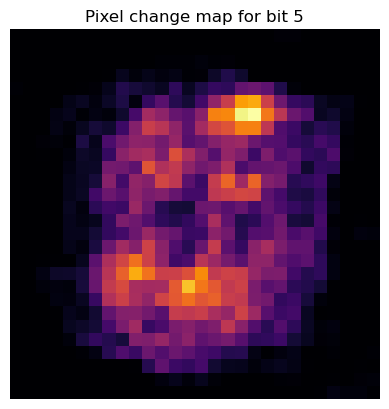

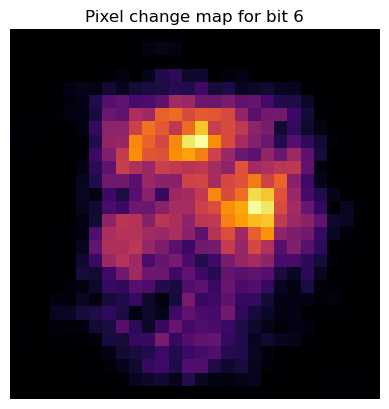

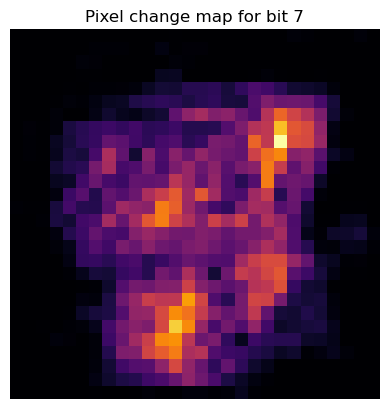

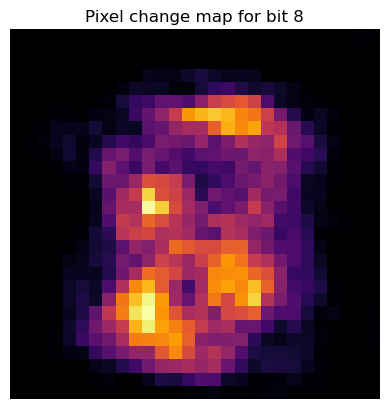

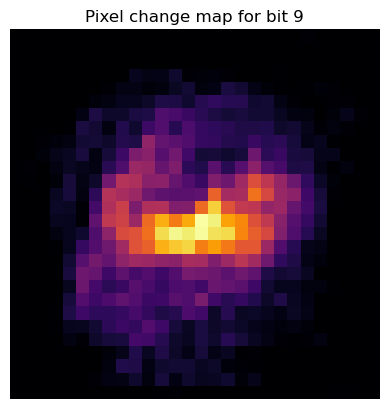

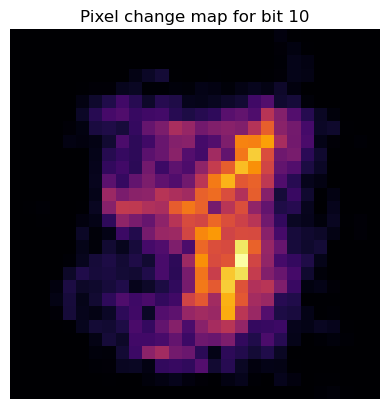

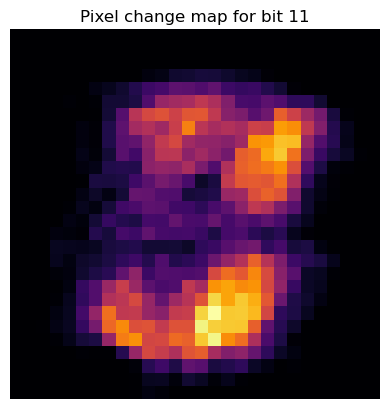

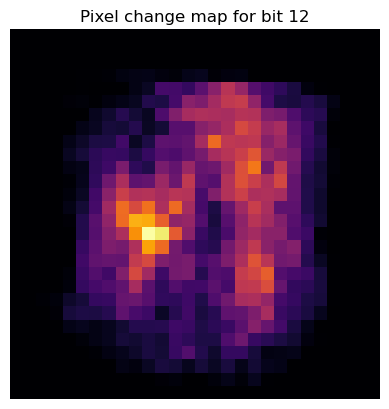

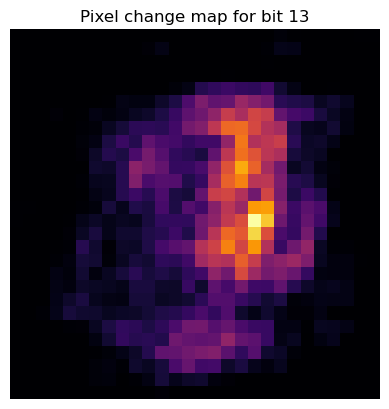

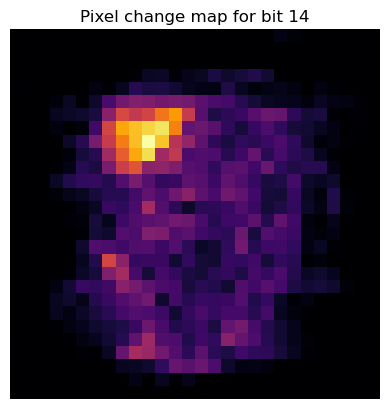

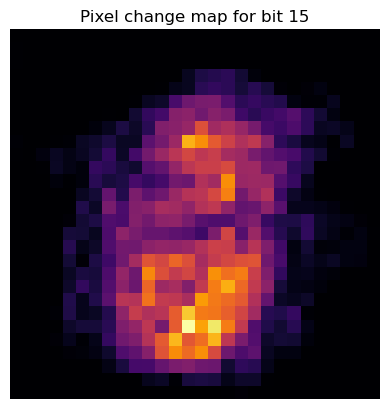

In [16]:
def bit_saliency_map(generator, bit_idx, device, n_samples=32):
    generator.eval()
    diffs = []
    for _ in range(n_samples):
        z = torch.randn(1, LATENT_DIM, device=device)
        m1 = torch.randint(0, 2, (1, MESSAGE_WIDTH), device=device, dtype=torch.float)
        m2 = m1.clone()
        m2[0, bit_idx] = 1 - m2[0, bit_idx]  # flip this bit only

        img1 = generator(z, m1).detach()
        img2 = generator(z, m2).detach()
        diff = (img1 - img2).abs().mean(1)[0]  # average over channels -> (H, W)
        diffs.append(diff.cpu().numpy())

    avg_map = np.mean(diffs, axis=0) # average across all samples
    avg_map = (avg_map - avg_map.min()) / (avg_map.max() - avg_map.min()) # normalize [0, 1]
    return avg_map

#bit_to_inspect = 0
for bit_to_inspect in range(MESSAGE_WIDTH):
    avg_map = bit_saliency_map(generator, bit_to_inspect, device)
    plt.imshow(avg_map, cmap='inferno')
    plt.title(f"Pixel change map for bit {bit_to_inspect}")
    plt.axis("off")
    plt.show()


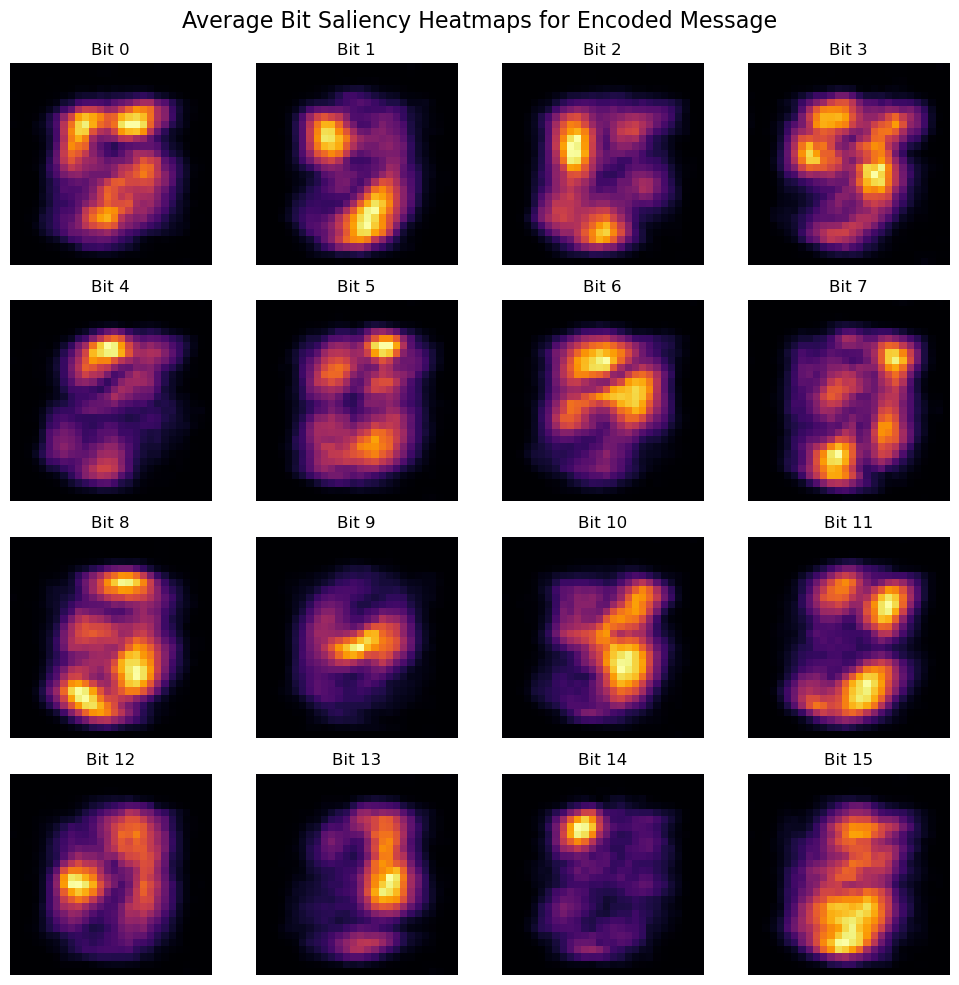

In [51]:
import matplotlib.pyplot as plt
import math

bit_maps = []
for bit_idx in range(MESSAGE_WIDTH):
    avg_map = bit_saliency_map(generator, bit_idx, device, n_samples=1024)
    bit_maps.append(avg_map)

cols = math.ceil(math.sqrt(MESSAGE_WIDTH))
rows = math.ceil(MESSAGE_WIDTH / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < MESSAGE_WIDTH:
        ax.imshow(bit_maps[i], cmap='inferno')
        ax.set_title(f"Bit {i}")
        ax.axis("off")
    else:
        ax.axis("off")

fig.suptitle("Average Bit Saliency Heatmaps for Encoded Message", fontsize=16)
plt.tight_layout()
plt.show()


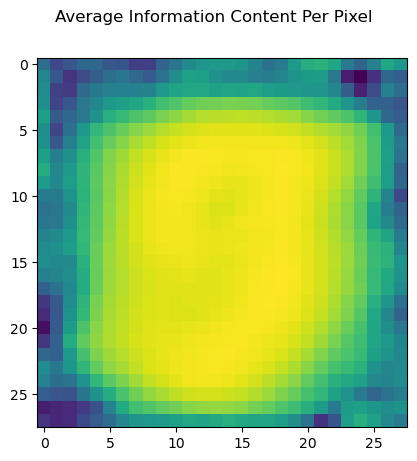

In [18]:
fig, ax = plt.subplots()
H = np.sum(np.array(bit_maps), axis=0)
ax.imshow(np.log(H / np.sum(H, axis=(0,1))))
fig.suptitle("Average Information Content Per Pixel")
fig.show()

In [19]:
!pip install grad-cam

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [Errno 16] Device or resource busy: '.nfs000000005f3456d000000bbe'



In [19]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [20]:
list(decoder.modules())

[Decoder(
   (model): Sequential(
     (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): LeakyReLU(negative_slope=0.2, inplace=True)
     (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (3): LeakyReLU(negative_slope=0.2, inplace=True)
     (4): Flatten(start_dim=1, end_dim=-1)
     (5): Linear(in_features=6272, out_features=256, bias=True)
     (6): LeakyReLU(negative_slope=0.2, inplace=True)
     (7): Linear(in_features=256, out_features=16, bias=True)
     (8): Sigmoid()
   )
 ),
 Sequential(
   (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): LeakyReLU(negative_slope=0.2, inplace=True)
   (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (3): LeakyReLU(negative_slope=0.2, inplace=True)
   (4): Flatten(start_dim=1, end_dim=-1)
   (5): Linear(in_features=6272, out_features=256, bias=True)
   (6): LeakyReLU(negative_slope=0.2, inplace=True)
   (7): Linear(in_features=256, ou

In [21]:
for i, layer in enumerate(decoder.modules()):
    if isinstance(layer, torch.nn.Conv2d):
        print(f"Layer {i}: {layer}")

Layer 2: Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Layer 4: Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


In [22]:
# Last conv layer
target_layer = list(decoder.modules())[4]

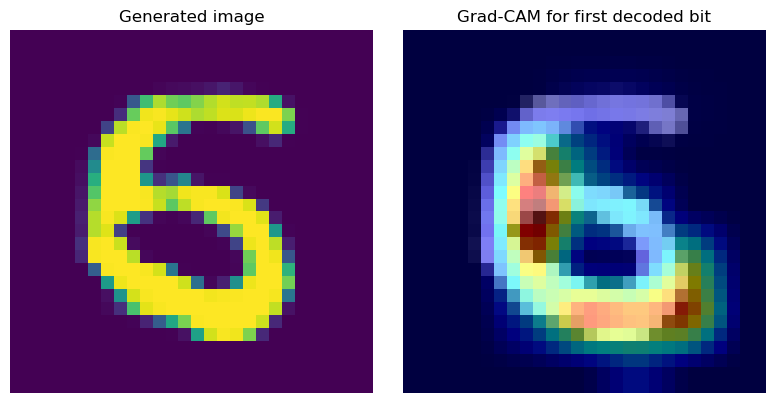

In [72]:
def gradcam_heatmap(generator, decoder, target_layer, z, msg, bit_idx, device):
    for p in decoder.parameters():
        p.requires_grad_(True)
    
    decoder.to(device)
    decoder.eval()

    generator.to(device)
    generator.eval()

    z = z.to(device)
    msg = msg.to(device)
    
    cam = GradCAM(
        model=decoder,
        target_layers=[target_layer],
    )

    with torch.enable_grad():
        # Generate image
        img = generator(z, msg)
        img = img.to(device)
        img.requires_grad_(True)
        
        # Decode message
        out = decoder(img)
        targets = [ClassifierOutputTarget(bit_idx)]

        # Grad-CAM
        grayscale_cam = cam(input_tensor=img, targets=targets, eigen_smooth=True, aug_smooth=False)
        cam_map = grayscale_cam[0]  # (H, W)

        img_cpu = img.detach().cpu().numpy()[0]          # C,H,W
        img_vis = np.transpose((img_cpu + 1) / 2, (1, 2, 0))  # H,W,C normalized to [0,1]

    return cam_map, img_vis


# Sample image
z = torch.randn(1, LATENT_DIM, device=device)
msg = torch.randint(0, 2, (1, MESSAGE_WIDTH), device=device, dtype=torch.float)

heatmap, img_vis = gradcam_heatmap(generator, decoder, target_layer, z, msg, bit_idx=0, device=device)

# Overlay heatmap on original image
overlay = show_cam_on_image(img_vis, heatmap, use_rgb=True)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img_vis); plt.title("Generated image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay); plt.title("Grad-CAM for first decoded bit"); plt.axis("off")
plt.tight_layout()
plt.show()


In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image

def plot_gradcam_bits(generator, decoder, target_layer, z, msg, message_width, device):
    img = generator(z.to(device), msg.to(device)).detach()
    img_vis = np.transpose((img[0].cpu().numpy() + 1) / 2, (1, 2, 0)) # normalize [0, 1]
    
    fig_cols = int(np.ceil(np.sqrt(message_width)))
    fig_rows = int(np.ceil(message_width / fig_cols))
    
    fig = plt.figure(figsize=(fig_cols*3, (fig_rows+1)*3 + 3))
    
    # Original image
    ax0 = fig.add_subplot(fig_rows + 1, fig_cols, (1, fig_cols))
    ax0.imshow(img_vis)
    ax0.set_title("Original Image")
    ax0.axis("off")
    
    # Compute Grad-CAM heatmaps
    for bit_idx in range(message_width):
        cam_map, _ = gradcam_heatmap(generator, decoder, target_layer, z, msg, bit_idx, device)
        overlay = show_cam_on_image(img_vis, cam_map, use_rgb=True)
        ax_idx = bit_idx + 1
        ax = fig.add_subplot(fig_rows + 1, fig_cols, ax_idx + fig_cols)
        ax.imshow(overlay)
        ax.set_title(f"Bit {bit_idx}")
        ax.axis("off")

    plt.suptitle("Grad-CAM Bit Saliency Heatmaps", fontsize=16)
    plt.tight_layout()
    plt.show()


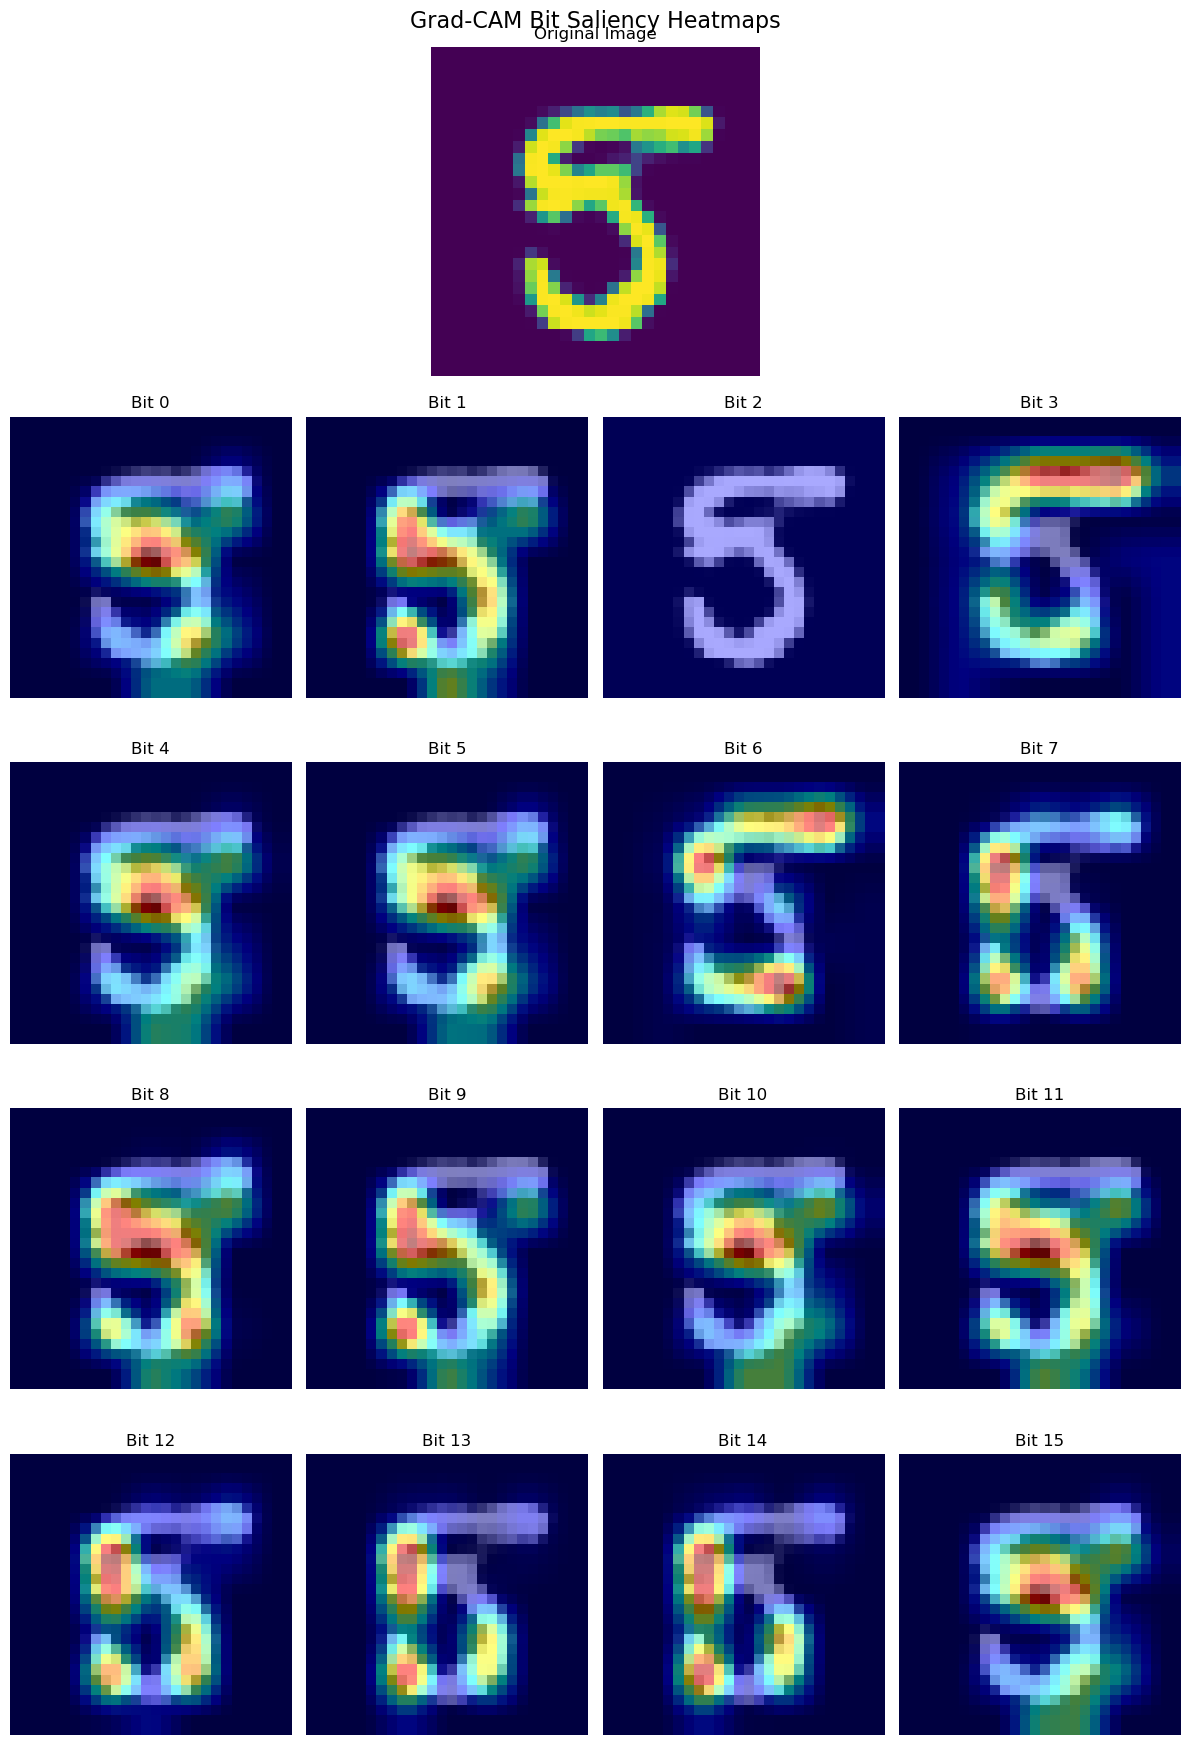

In [50]:
z = torch.randn(1, LATENT_DIM, device=device)
msg = torch.randint(0, 2, (1, MESSAGE_WIDTH), dtype=torch.float, device=device)
plot_gradcam_bits(generator, decoder, target_layer, z, msg, MESSAGE_WIDTH, device)